In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tejapi
import pickle
import optuna
# from scripts.config import *
# from scripts.factors import *
from load_data import DataManager
import pandas as pd
import numpy as np
import tqdm
import os
import cufflinks as cf
cf.go_offline()
import quantstats as qs
qs.extend_pandas()
import pandas_ta as ta
import tqdm

In [3]:
class Handler(dict):
    def __init__(self, path: str = 'Handler_cache'):
        self.path = path
        os.makedirs(self.path, exist_ok=True)
    
    def __getitem__(self, key):
        file_path = os.path.join(self.path, f'{key}.pkl')
        if os.path.exists(file_path):
            try:
                with open(file_path, 'rb') as f:
                    return pickle.load(f)
            except (pickle.PickleError, EOFError) as e:
                raise KeyError(f"Failed to load key '{key}': {e}")
        else:
            raise KeyError(f"Key '{key}' not found.")
    def __setitem__(self, key, value):
        file_path = os.path.join(self.path, f'{key}.pkl')
        with open(file_path, 'wb') as f:
            pickle.dump(value, f)

    def cash_list(self):
        pkl_set = set(filter(lambda X:X.endswith(".pkl"),os.listdir(self.path)))
        return list(map(lambda X:X[:-4],list(pkl_set)))

    @property
    def info(self):
        return {
            'cache_path': self.path,
            'cache_data_numbers': len(self.cash_list()),
        }

    def _repr_html_(self):
        html = "<table>"
        html += "<tr><th>Key</th><th>Value</th></tr>"
        for key, value in self.info.items():
            html += f"<tr><td>{key}</td><td>{value}</td></tr>"
        html += "</table>"
        return html

# 存資料

In [4]:
Cache_Handler = Handler()
manage = DataManager()

In [375]:
combined_list = [
    '現金及約當現金', '應收帳款', '長期應收款', '存貨', '應付帳款', '固定資產', '無形資產', '預付款', '其他應收款',
    '預收款_流動', '預收款_非流動', '金融借款_流動', '金融借款_非流動', '非金融借款_流動', '非金融借款_非流動',
    '普通股股本', '資本公積', '保留盈餘', '非控制權益', '流動資產合計', '非流動資產合計', '資產總計',
    '流動負債合計', '非流動負債合計', '負債總額', '股東權益總計', '長短期借款', '速動資產', 
    '生財設備','長短期應收帳款', '營業總收入', '營業總成本', '營業費用','利息收入', '利息支出', '營業毛利率', '營業利益', '常續性利益',
    '稅前息前淨利', '折舊及攤提', '營運產生現金流量', '投資產生現金流量', '融資產生現金流量', '員工人數',
    '加權平均股數', '稅率', '常續ROE', '常續ROA', '營業毛利率', '營業利益率', '稅前淨利率',
    '稅後淨利率', '營業費用率', '營收成長率', '營業毛利成長率', '營業利益成長率', '稅前淨利成長率',
    '稅後淨利成長率', '資產成長率', '淨值成長率', '固定資產成長率', '速動比率', '流動比率', '現金流量比率',
    '負債比率', '利息支出率', '利息保障倍數', '借款依存度', '應收帳款週轉率', '應付帳款週轉率', '存貨週轉率',
    '總資產週轉率', '淨值週轉率', '固定資產週轉率', '期末收帳天數', '期末售貨天數', '每股淨值',
    '每股營業收入', '每股營業利益', '每股稅後淨利', '每人營收','收盤價','開盤價','最低價',
    '成交量_千股','個股市值_元','營業總收入','股價淨值比','母公司每股盈餘','股利殖利率','毛利','外資持股率','外資買進金額_元'
    '調整係數'
]


In [376]:
def manage_factors(Cache_Handler, factor_list):
    for factor_name in factor_list:
        if factor_name not in Cache_Handler:
            factor_data = manage.tool_api_data(factor_name)
            
            if isinstance(factor_data.columns, pd.MultiIndex):
                if len(factor_data.columns.get_level_values(0).unique()) == 1:
                    factor_data = factor_data  
                else:
                    factor_data = factor_data.loc[:, factor_data.columns.get_level_values(0).str.endswith('_Q')]
                    factor_data.columns = factor_data.columns.droplevel(0)
            else:
                # 單純的資料，直接保留
                factor_data = factor_data
                factor_data.columns = factor_data.columns.droplevel(0)
            
            Cache_Handler[factor_name] = factor_data
    return Cache_Handler

factors = manage_factors(Cache_Handler, combined_list)

資料集 '調整係數' 包含其他欄位（['Adjust_Factor']），進行 pivot 操作。


In [90]:
def manage_factors(Cache_Handler):
    factors = []

    def add_factor(factor_name, formula):
        if factor_name not in factors:
            factors.append(factor_name)
        Cache_Handler[factor_name] = formula

    # Define factors
    add_factor('MoM_126', Cache_Handler['收盤價'] / Cache_Handler['收盤價'].shift(126) - 1)
    add_factor('MoM_252', Cache_Handler['收盤價'] / Cache_Handler['收盤價'].shift(252) - 1)
    add_factor('reversal', Cache_Handler['收盤價'].shift(21) / Cache_Handler['收盤價'] - 1)
    add_factor('52_high', Cache_Handler['收盤價'] / Cache_Handler['收盤價'].rolling(252).max())
    add_factor('cash_flow_market_value', Cache_Handler['營運產生現金流量'] / Cache_Handler['個股市值_元'])
    add_factor('cash_flow_variance', Cache_Handler['營運產生現金流量'].rolling(window=60).var())
    add_factor('Book_to_Market_Equity', np.log(Cache_Handler['股價淨值比']))
    add_factor('Dividend_Yield', 1 / Cache_Handler['股利殖利率'])
    add_factor('BP_60d_Change', 1 / Cache_Handler['股價淨值比'] - 1 / Cache_Handler['股價淨值比'].shift(60))
    add_factor('EP', Cache_Handler['母公司每股盈餘'] / Cache_Handler['收盤價'])
    add_factor('EP_60d_Change', 1 / Cache_Handler['EP'] - 1 / Cache_Handler['EP'].shift(60))
    EV = Cache_Handler['個股市值_元'] + Cache_Handler['負債總額'] - Cache_Handler['現金及約當現金']
    add_factor('EBIT_to_EV', Cache_Handler['稅前息前淨利'] / EV)
    bp_quantile = Cache_Handler['股價淨值比'].rank(pct=True).apply(lambda x: 1 / x)
    roe_quantile = Cache_Handler['常續ROE'].rank(pct=True).apply(lambda x: 1 / x)
    add_factor('BPROE_Quantile', bp_quantile + roe_quantile)
    add_factor('Log PS', Cache_Handler['營業總收入'] / Cache_Handler['個股市值_元'].apply(np.log))
    add_factor('GPOA', Cache_Handler["毛利"] / Cache_Handler['資產總計'] )
    add_factor('return on current asset', Cache_Handler['流動資產合計'] / Cache_Handler['股東權益總計'])
    add_factor('ROA', Cache_Handler['常續ROA'])
    add_factor('ROE', Cache_Handler['常續ROE'])
    add_factor('Gross Profit', Cache_Handler['毛利'])
    add_factor('Total_Operating_Income', Cache_Handler['營業總收入'])
    add_factor('5 day Change in Holding Percentage', Cache_Handler['外資持股率'].diff(5))
    add_factor('60 day Change in Holding Percentage', Cache_Handler['外資持股率'].diff(60))
    add_factor('5 day net inflow', Cache_Handler['外資買進金額_元'].rolling(5).sum())
    add_factor('60 day net inflow', Cache_Handler['外資買進金額_元'].rolling(60).sum())
    add_factor('1 month turnover', Cache_Handler['成交量_千股'].rolling(20).sum() / Cache_Handler['流通在外股數_千股'])
    add_factor('3 month turnover', Cache_Handler['成交量_千股'].rolling(60).sum() / Cache_Handler['流通在外股數_千股'])
    add_factor('turnover', Cache_Handler['成交量_千股'] / Cache_Handler['流通在外股數_千股'])
    add_factor('volume_20d', Cache_Handler['成交量_千股'].rolling(20).mean() / Cache_Handler['個股市值_元'])
    add_factor('returns_20d', Cache_Handler['收盤價'].pct_change().rolling(20).sum())
    add_factor('One-month change', Cache_Handler['收盤價'] - Cache_Handler['收盤價'].shift(20) / Cache_Handler['收盤價'].shift(20) )
    
    return factors
factors = manage_factors(Cache_Handler)

c:\Users\User\anaconda3\anaconda\envs\tej\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning:

divide by zero encountered in log

C:\Users\User\AppData\Local\Temp\ipykernel_35876\100764484.py:41: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



In [92]:
growth_and_sue_columns = [
    "單月營收_千元",
    "去年單月營收_千元",
    "累計營收_千元",
    "去年累計營收_千元",
    "近12月累計營收_千元",
    "去年近12月累計營收_千元",
    "近3月累計營收_千元",
    "去年近3月累計營收_千元",
    "單月每股營收_元",
    "累計每股營收_元",
    "近12月每股營收_元",
    "近3月每股營收_元",
    '單月營收成長率',
    '單月營收與上月比',
    '累計營收成長率',
    '與歷史最高單月營收比',
    '與歷史最低單月營收比',
    '近12月累計營收成長率',
    '近3月累計營收成長率',
    '近3月累計營收與上月比',
    '近3月累計營收變動率'
     
]

In [91]:
def manage_factors(Cache_Handler, factor_list):
    for factor_name in factor_list:
        if factor_name not in Cache_Handler:
            factor_data = manage.tool_api_data(factor_name)
            factor_data.columns = factor_data.columns.droplevel(0)
            Cache_Handler[factor_name] = factor_data
    return Cache_Handler
factors = manage_factors(Cache_Handler, growth_and_sue_columns)

資料集 '單月營收_千元' 包含其他欄位（['Sales_Monthly']），進行 pivot 操作。
資料集 '去年單月營收_千元' 包含其他欄位（['Sales_Monthly_LastYear']），進行 pivot 操作。
資料集 '累計營收_千元' 包含其他欄位（['Sales_Accumulated']），進行 pivot 操作。
資料集 '去年累計營收_千元' 包含其他欄位（['Sales_Accu_LastYear']），進行 pivot 操作。
資料集 '近12月累計營收_千元' 包含其他欄位（['Sales_Accu_12M']），進行 pivot 操作。
資料集 '去年近12月累計營收_千元' 包含其他欄位（['Sales_Accu_12M_Last_Year']），進行 pivot 操作。
資料集 '近3月累計營收_千元' 包含其他欄位（['Sales_Accu_3M']），進行 pivot 操作。
資料集 '去年近3月累計營收_千元' 包含其他欄位（['Sales_Accu_3M_LastYear']），進行 pivot 操作。
資料集 '單月每股營收_元' 包含其他欄位（['Sales_Per_Share_Single_Month']），進行 pivot 操作。
資料集 '累計每股營收_元' 包含其他欄位（['Sales_Per_Share_Accu']），進行 pivot 操作。
資料集 '近12月每股營收_元' 包含其他欄位（['Sales_Per_Share_Accu_12M']），進行 pivot 操作。
資料集 '近3月每股營收_元' 包含其他欄位（['Sales_Per_Share_Accu_3M']），進行 pivot 操作。
資料集 '單月營收成長率' 包含其他欄位（['YoY_Monthly_Sales']），進行 pivot 操作。
資料集 '單月營收與上月比' 包含其他欄位（['MoM_Monthly_Sales']），進行 pivot 操作。
資料集 '累計營收成長率' 包含其他欄位（['YoY_Accu_Sales']），進行 pivot 操作。
資料集 '與歷史最高單月營收比' 包含其他欄位（['Month_Sales_Compared_To_High_Month_Sales_MoM']），進行 pivot 

In [93]:
from factor_generator import calculate_growth, calculate_sue
def process_growth_and_sue(columns, Cache_Handler, diff_period=63, drift_window=190, std_window=126):
    results = {}
    for column in columns:
        df = Cache_Handler[column]
        
        growth_result = calculate_growth(df, diff_period=diff_period)
        Cache_Handler[f"{column}_growth"] = growth_result
        results[f"{column}_growth"] = growth_result
        sue_result = calculate_sue(df, drift_window=drift_window, 
                                   diff_window=diff_period, std_window=std_window)
        Cache_Handler[f"{column}_sue"] = sue_result

    return results

columns = growth_and_sue_columns
process_growth_and_sue(columns, Cache_Handler)

print("Updated Cache_Handler keys:")
print(Cache_Handler.keys())

Updated Cache_Handler keys:
dict_keys([])


In [29]:
# final_list = [
#     'MoM_126',
#     'MoM_252',
#     'reversal',
#     '52_high',
#     'cash_flow_market_value',
#     'cash_flow_variance',
#     'Book_to_Market_Equity',
#     # 'Earnings_to_Price',  # 已被註解
#     'Dividend_Yield',
#     'BP_60d_Change',
#     'EP',
#     'EP_60d_Change',
#     'EBIT_to_EV',
#     'Inverse_Operating_Income_to_P',
#     'BPROE_Quantile',
#     'Log PS',
#     'GPOA',
#     'return on current asset',
#     'ROA',
#     'ROE',
#     'Gross Profit',
#     'Net_Income_Attributable_to_Parent',
#     'Total_Operating_Income',
#     '5 day Change in Holding Percentage',
#     '60 day Change in Holding Percentage',
#     ' 5 day net inflow',
#     ' 60 day net inflow',
#     '1 month turnover',
#     '3 month turnover',
#     'turnover',
#     'volume_20d',
#     'returns_20d',
#     'One-month change',
#     '現金及約當現金', '應收帳款', '長期應收款', '存貨', '應付帳款', '固定資產', '無形資產', '預付款', '其他應收款',
#     '預收款_流動', '預收款_非流動', '金融借款_流動', '金融借款_非流動', '非金融借款_流動', '非金融借款_非流動',
#     '普通股股本', '資本公積', '保留盈餘', '非控制權益', '流動資產合計', '非流動資產合計', '資產總計',
#     '流動負債合計', '非流動負債合計', '負債總額', '股東權益總計', '長短期借款', '速動資產', 
#     '生財設備','長短期應收帳款', '營業總收入', '營業總成本', '營業費用','利息收入', '利息支出', '營業毛利率', '營業利益', '常續性利益',
#     '稅前息前淨利', '折舊及攤提', '營運產生現金流量', '投資產生現金流量', '融資產生現金流量', '員工人數',
#     '加權平均股數', '稅率', '常續ROE', '常續ROA', '營業毛利率', '營業利益率', '稅前淨利率',
#     '稅後淨利率', '營業費用率', '營收成長率', '營業毛利成長率', '營業利益成長率', '稅前淨利成長率',
#     '稅後淨利成長率', '資產成長率', '淨值成長率', '固定資產成長率', '速動比率', '流動比率', '現金流量比率',
#     '負債比率', '利息支出率', '利息保障倍數', '借款依存度', '應收帳款週轉率', '應付帳款週轉率', '存貨週轉率',
#     '總資產週轉率', '淨值週轉率', '固定資產週轉率', '期末收帳天數', '期末售貨天數', '每股淨值',
#     '每股營業收入', '每股營業利益', '每股稅後淨利', '每人營收','收盤價','開盤價','最低價',
#     '成交量_千股','個股市值_元','營業總收入','股價淨值比','母公司每股盈餘','股利殖利率','毛利'
# ]

In [5]:
close = Cache_Handler['收盤價']
close.columns  = close.columns.droplevel(0)
adjust_factor = Cache_Handler['調整係數']
adjust_factor.columns = adjust_factor.columns.droplevel(0)
adj_close= close * adjust_factor
daily_return_data = manage.tool_api_data('報酬率')
daily_return_data.columns = daily_return_data.columns.droplevel(0)
exp_ret = adj_close.shift(-2) / adj_close.shift(-1) - 1
def get_IC_Se(Factor,exp_ret):
    Factor.columns = exp_ret.columns
    IC_se = Factor.corrwith(exp_ret,method='spearman',axis = 1)
    return IC_se

資料集 '報酬率' 包含其他欄位（['ROI']），進行 pivot 操作。


In [7]:
end_date = '2021-01-01'
def objective(trial):
    global factor_attempts  

    # Trial parameter suggestions
    資料名稱1 = trial.suggest_categorical("資料名稱1", combined_list)
    資料時序處理方法 = trial.suggest_categorical(
        "資料時序處理方法", 
        [
            'ts_mean', 'ts_std', "ts_sharpe", 'ts_max', 'ts_skew', 
            'ts_min', 'ts_median', 'ts_delta', 'ts_kurtosis', 
            'ts_sum', 'ts_scale', 'ts_percentage','ts_max_diff',
            'ts_min_diff','ts_rank',"ts_excess_high_rate",
        ]
    )
    資料時序參數 = trial.suggest_int("資料時序參數", 5, 250, step=5)
    資料橫節面處理方法 = trial.suggest_categorical("資料橫節面處理方法", ['cs_rank', 'cs_zscore', 'cs_log'])

    # Load and preprocess data
    Data_df = Cache_Handler[資料名稱1]
    Data_df = Data_df.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Apply time-series processing methods
    if 資料時序處理方法 == 'ts_mean':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).mean()
    elif 資料時序處理方法 == 'ts_std':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).std()
    elif 資料時序處理方法 == 'ts_sharpe':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).mean() / Data_df.rolling(window=資料時序參數, min_periods=1).std()
    elif 資料時序處理方法 == 'ts_max':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).max()
    elif 資料時序處理方法 == 'ts_skew':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).skew()
    elif 資料時序處理方法 == 'ts_min':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).min()
    elif 資料時序處理方法 == 'ts_median':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).median()
    elif 資料時序處理方法 == 'ts_delta':
        Data_df = Data_df.shift(資料時序參數) / Data_df - 1  
    elif 資料時序處理方法 == 'ts_kurtosis':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).kurt()
    elif 資料時序處理方法 == 'ts_sum':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).sum()
    elif 資料時序處理方法 == 'ts_scale':
        Data_df = (Data_df - Data_df.rolling(window=資料時序參數).min()) / (
        Data_df.rolling(window=資料時序參數, min_periods=1).max() - Data_df.rolling(window=資料時序參數).min())
    elif 資料時序處理方法 == 'ts_percentage':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).quantile(0.1)
    elif 資料時序處理方法 == 'ts_max_diff':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).max() / Data_df
    elif 資料時序處理方法 == 'ts_min_diff':
        Data_df = Data_df.rolling(window=資料時序參數,min_periods=1).min() / Data_df
    elif 資料時序處理方法 == 'ts_rank':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).rank()
    elif 資料時序處理方法 == 'ts_excess_high_rate':
        historical_high = Data_df.rolling(window=資料時序參數, min_periods=1).max().shift(1)
        Data_df = (Data_df - historical_high)/np.abs(historical_high)
        Data_df = Data_df.replace([float('inf'), -float('inf')], np.nan)*100

    # Apply cross-sectional processing methods
    if 資料橫節面處理方法 == 'cs_rank':
        Data_df = Data_df.rank(axis=1)
    elif 資料橫節面處理方法 == 'cs_zscore':
        Data_df = Data_df.replace([np.inf, -np.inf], np.nan)
        mean = Data_df.mean(axis=1, skipna=True)
        std = Data_df.std(axis=1, skipna=True)
        std = std.replace(0, np.nan)
        Data_df = (Data_df.sub(mean, axis=0)).div(std, axis=0)
    elif 資料橫節面處理方法 == 'cs_log':
        Data_df = Data_df.fillna(0)
        Data_df[Data_df < 0] = 0
        Data_df = np.log(Data_df[Data_df != 0])

    # Calculate IC and filter data for specified date range
    IC_Se = get_IC_Se(Data_df, exp_ret).loc['2010-01-02':end_date]

    # Check if IC values are valid for more than half the days
    valid_ic_days = IC_Se.notna().sum()
    total_days = IC_Se.shape[0]
    if valid_ic_days < total_days / 2:
        return -100000

    # Check if each day has data for more than half of the stocks
    valid_data_days = (Data_df.notna().sum(axis=1) > (Data_df.shape[1] / 2)).sum()
    if valid_data_days < total_days / 2:
        return -100000

    # Calculate IC mean and IR
    trial.set_user_attr("IC_mean", abs(IC_Se.mean()))
    trial.set_user_attr("IR", abs(IC_Se.mean()) / IC_Se.std())

    if IC_Se.std() == 0:
        return -10000
    elif abs(IC_Se.mean()) < 0.03:
        return -10000
    elif abs(IC_Se.mean()) / IC_Se.std() < 0.3:
        return -20000

    # Calculate score
    Score = (abs(IC_Se).mean() / IC_Se.std()) + 10 * abs(IC_Se.mean())

    return Score

In [14]:
%%time
study = optuna.create_study(
    study_name="example_study", 
    storage="sqlite:///example_study.db",  
    load_if_exists=True,
    direction="maximize",
)
study.optimize(objective, n_trials = 5000)
trials_dataframe = study.trials_dataframe()
# Showing optimization results
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', study.best_trial.params)
print('Best score:', study.best_value)
print(trials_dataframe[['user_attrs_IC_mean', 'user_attrs_IR']])

[I 2025-01-10 11:12:04,983] A new study created in RDB with name: example_study
c:\Users\User\anaconda3\anaconda\envs\tej\Lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

[I 2025-01-10 11:12:12,199] Trial 0 finished with value: -10000.0 and parameters: {'資料名稱1': '速動比率', '資料時序處理方法': 'ts_max_diff', '資料時序參數': 95, '資料橫節面處理方法': 'cs_rank'}. Best is trial 0 with value: -10000.0.
c:\Users\User\anaconda3\anaconda\envs\tej\Lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

[I 2025-01-10 11:12:19,217] Trial 1 finished with value: -10000.0 and parameters: {'資料名稱1': '加權平均股數', '資料時序處理方法': 'ts_rank', '資料時序參數': 10, '資料橫節面處理方法': 'cs_rank'}. Best is trial 0 with value: -10000.0.
c:\Users\User\anaconda3\anaconda\envs\tej\Lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning:

An input array is constant; the cor

KeyboardInterrupt: 

In [15]:
import csv
study = optuna.load_study(
    study_name="example_study",  
    storage="sqlite:///example_study.db",  
)
trials_dataframe = study.trials_dataframe()
trials_dataframe.to_csv('trials_dataframe7.csv')
# trials_dataframe = pd.read_csv('trials_dataframe5.csv')
trials_dataframe

number          value             datetime_start  \
0          0  -10000.000000 2025-01-10 11:12:05.017209   
1          1  -10000.000000 2025-01-10 11:12:12.209590   
2          2  -10000.000000 2025-01-10 11:12:19.226148   
3          3  -10000.000000 2025-01-10 11:12:25.471413   
4          4 -100000.000000 2025-01-10 11:12:31.425797   
...      ...            ...                        ...   
1235    1235  -10000.000000 2025-01-10 16:20:01.631971   
1236    1236       1.446516 2025-01-10 16:20:06.774243   
1237    1237  -10000.000000 2025-01-10 16:20:12.022732   
1238    1238  -10000.000000 2025-01-10 16:20:17.380360   
1239    1239            NaN 2025-01-10 16:20:22.669708   

              datetime_complete               duration params_資料名稱1  \
0    2025-01-10 11:12:12.174482 0 days 00:00:07.157273         速動比率   
1    2025-01-10 11:12:19.195137 0 days 00:00:06.985547       加權平均股數   
2    2025-01-10 11:12:25.437495 0 days 00:00:06.211347          預付款   
3    2025-01-10 11:12:31.392002 0 days 00:00:05.920589        利息支出率   
4    2025-01-10 11:12:37.160529 0 days 00:00:05.734732      應付帳款週轉率   
...                         ...                    ...          ...   
1235 2025-01-10 16:20:06.746326 0 days 00:00:05.114355        股利殖利率   
1236 2025-01-10 16:20:11.994173 0 days 00:00:05.219930        營業毛利率   
1237 2025-01-10 16:20:17.351508 0 days 00:00:05.328776        營業總收入   
1238 2025-01-10 16:20:22.641750 0 days 00:00:05.261390        股價淨值比   
1239 2025-01-10 16:20:23.223376 0 days 00:00:00.553668        常續性利益   

      params_資料時序參數      params_資料時序處理方法 params_資料橫節面處理方法  user_attrs_IC_mean  \
0                95          ts_max_diff          cs_rank            0.007329   
1                10              ts_rank          cs_rank            0.004214   
2               175          ts_max_diff           cs_log            0.002736   
3                35             ts_scale        cs_zscore            0.014946   
4               100          ts_kurtosis           cs_log                 NaN   
...             ...                  ...              ...                 ...   
1235            235               ts_std        cs_zscore            0.009779   
1236            245             ts_scale        cs_zscore            0.038636   
1237            250             ts_scale        cs_zscore            0.027020   
1238            240  ts_excess_high_rate        cs_zscore            0.025789   
1239            250               ts_min        cs_zscore                 NaN   

      user_attrs_IR     state  
0          0.208506  COMPLETE  
1          0.123283  COMPLETE  
2          0.076788  COMPLETE  
3          0.087467  COMPLETE  
4               NaN  COMPLETE  
...             ...       ...  
1235       0.145426  COMPLETE  
1236       0.805859  COMPLETE  
1237       0.425287  COMPLETE  
1238       0.169015  COMPLETE  
1239            NaN      FAIL  

[1240 rows x 12 columns]

In [280]:
def get_factor(trials_dataframe_:pd.Series,Cache_Handler:Handler):
    資料名稱1 = trials_dataframe_['params_資料名稱1']
    Data_df= Cache_Handler[資料名稱1]
    Data_df = Data_df.apply(pd.to_numeric, errors='coerce').fillna(0)

    資料時序處理方法 = trials_dataframe_['params_資料時序處理方法']
    資料時序參數 = trials_dataframe_['params_資料時序參數']
    if 資料時序處理方法 == 'ts_mean':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).mean()
    elif 資料時序處理方法 == 'ts_std':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).std()
    elif 資料時序處理方法 == 'ts_sharpe':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).mean() / Data_df.rolling(window=資料時序參數, min_periods=1).std()
    elif 資料時序處理方法 == 'ts_max':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).max()
    elif 資料時序處理方法 == 'ts_skew':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).skew()
    elif 資料時序處理方法 == 'ts_min':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).min()
    elif 資料時序處理方法 == 'ts_median':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).median()
    elif 資料時序處理方法 == 'ts_delta':
        Data_df = Data_df.shift(資料時序參數) / Data_df - 1  
    elif 資料時序處理方法 == 'ts_kurtosis':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).kurt()
    elif 資料時序處理方法 == 'ts_sum':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).sum()
    elif 資料時序處理方法 == 'ts_scale':
        Data_df = (Data_df - Data_df.rolling(window=資料時序參數).min()) / (
            Data_df.rolling(window=資料時序參數, min_periods=1).max() - Data_df.rolling(window=資料時序參數).min())
    elif 資料時序處理方法 == 'ts_percentage':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).quantile(0.1)
    elif 資料時序處理方法 == 'ts_max_diff':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).max() / Data_df
    elif 資料時序處理方法 == 'ts_min_diff':
        Data_df = Data_df.rolling(window=資料時序參數,min_periods=1).min() / Data_df
    elif 資料時序處理方法 == 'ts_rank':
        Data_df = Data_df.rolling(window=資料時序參數, min_periods=1).rank()
    elif 資料時序處理方法 == 'ts_excess_high_rate':
        historical_high = Data_df.rolling(window=資料時序參數, min_periods=1).max().shift(1)
        Data_df = (Data_df - historical_high)/np.abs(historical_high)
        Data_df = Data_df.replace([float('inf'), -float('inf')], np.nan)*100
        
        
    資料橫節面處理方法 = trials_dataframe_['params_資料橫節面處理方法']

    if 資料橫節面處理方法 == 'cs_rank':
            Data_df = Data_df.rank(axis=1)
    elif 資料橫節面處理方法 == 'cs_zscore':
        Data_df = Data_df.replace([np.inf, -np.inf], np.nan)
        mean = Data_df.mean(axis=1, skipna=True)
        std = Data_df.std(axis=1, skipna=True)
        std = std.replace(0, np.nan)
        Data_df = (Data_df.sub(mean, axis=0)).div(std, axis=0)
    elif 資料橫節面處理方法 == 'cs_log':
        Data_df = Data_df.fillna(0)
        Data_df[Data_df < 0] = 0
        Data_df = np.log(Data_df[Data_df != 0])
    elif 資料橫節面處理方法 == 'cs_sigmoid':
        negative_mask = Data_df < 0
        positive_mask = ~negative_mask
        Data_df[negative_mask] = np.exp(Data_df[negative_mask]) / (1 + np.exp(Data_df[negative_mask]))
        Data_df[positive_mask] = 1 / (1 + np.exp(-Data_df[positive_mask]))


    return Data_df

In [7]:
trials_dataframe = trials_dataframe.drop_duplicates(subset=['params_資料名稱1', 
                                                                'params_資料時序處理方法', 
                                                                'params_資料橫節面處理方法'])
top_trials = trials_dataframe.sort_values('value', ascending=False).head(20).reset_index()
top_trials

NameError: name 'trials_dataframe' is not defined

# 復現用

In [6]:
trials1 = pd.read_csv('trials_dataframe1.csv')
trials2 = pd.read_csv('trials_dataframe2.csv')
trials3 = pd.read_csv('trials_dataframe3.csv')
trials4 = pd.read_csv('trials_dataframe4.csv')
trials5 = pd.read_csv('trials_dataframe5.csv')
trials6 = pd.read_csv('trials_dataframe6.csv')
trials7 = pd.read_csv('trials_dataframe7.csv')
growth1 = pd.read_csv('growth1.csv')
growth2 = pd.read_csv('growth2.csv')
growth3 = pd.read_csv('growth3.csv')
growth4 = pd.read_csv('growth4.csv')
trials_dataframe = pd.concat([trials1, trials2, trials3, trials4, trials5,trials6,trials7, growth1, growth2, growth3, growth4], axis=0, ignore_index=True)
trials_dataframe

Unnamed: 0  number    value              datetime_start  \
0               0       0 -10000.0  2025-01-06 12:05:35.043452   
1               1       1 -10000.0  2025-01-06 12:05:42.447211   
2               2       2 -10000.0  2025-01-06 12:05:49.597803   
3               3       3 -10000.0  2025-01-06 12:05:54.408006   
4               4       4 -10000.0  2025-01-06 12:05:59.748831   
...           ...     ...      ...                         ...   
32002        1369    1369 -10000.0  2025-01-10 16:19:24.947893   
32003        1370    1370 -10000.0  2025-01-10 16:19:29.643212   
32004        1371    1371 -10000.0  2025-01-10 16:19:33.932707   
32005        1372    1372 -10000.0  2025-01-10 16:19:39.518423   
32006        1373    1373      NaN  2025-01-10 16:19:44.895222   

                datetime_complete                duration  \
0      2025-01-06 12:05:42.413803  0 days 00:00:07.370351   
1      2025-01-06 12:05:49.566952  0 days 00:00:07.119741   
2      2025-01-06 12:05:54.379658  0 days 00:00:04.781855   
3      2025-01-06 12:05:59.720637  0 days 00:00:05.312631   
4      2025-01-06 12:06:06.249197  0 days 00:00:06.500366   
...                           ...                     ...   
32002  2025-01-10 16:19:29.605494  0 days 00:00:04.657601   
32003  2025-01-10 16:19:33.904979  0 days 00:00:04.261767   
32004  2025-01-10 16:19:39.489888  0 days 00:00:05.557181   
32005  2025-01-10 16:19:44.863030  0 days 00:00:05.344607   
32006  2025-01-10 16:19:49.649242  0 days 00:00:04.754020   

                              params_資料名稱1  params_資料時序參數 params_資料時序處理方法  \
0      60 day Change in Holding Percentage           70.0   ts_percentage   
1               Cash_and_Cash_Equivalent_Q           80.0       ts_median   
2                                 reversal           50.0          ts_sum   
3                 Book_Value_Per_Share_A_A          115.0        ts_scale   
4                 Total_Operating_Income_A          175.0   ts_percentage   
...                                    ...            ...             ...   
32002                    與歷史最低單月營收比_growth          235.0     ts_min_diff   
32003                     去年累計營收_千元_growth          230.0          ts_std   
32004                             單月營收與上月比          220.0        ts_scale   
32005                              單月營收成長率          225.0       ts_sharpe   
32006                              單月營收成長率          235.0        ts_scale   

      params_資料橫節面處理方法  user_attrs_IC_mean  user_attrs_IR     state  
0              cs_rank            0.008128       0.105016  COMPLETE  
1            cs_zscore            0.023429       0.262036  COMPLETE  
2            cs_zscore            0.007325       0.057027  COMPLETE  
3           cs_sigmoid            0.026033       0.370182  COMPLETE  
4            cs_zscore            0.027440       0.303390  COMPLETE  
...                ...                 ...            ...       ...  
32002        cs_zscore            0.010954       0.298055  COMPLETE  
32003        cs_zscore            0.002905       0.075269  COMPLETE  
32004        cs_zscore            0.001354       0.029063  COMPLETE  
32005        cs_zscore            0.015653       0.212949  COMPLETE  
32006        cs_zscore                 NaN            NaN      FAIL  

[32007 rows x 13 columns]

In [7]:
trials_dataframe = trials_dataframe.loc[
    trials_dataframe.groupby(['params_資料名稱1', 'params_資料時序處理方法', 'params_資料橫節面處理方法'])['value'].idxmax()]
top_trials = trials_dataframe.sort_values('value', ascending=False).reset_index()
top_trials[10:70]

index  Unnamed: 0  number     value              datetime_start  \
10    533         533     533  2.128246  2025-01-06 13:47:38.741438   
11    424         424     424  2.126277  2025-01-06 13:28:36.457732   
12    387         387     387  2.107267  2025-01-06 13:22:11.405056   
13    420         420     420  2.075246  2025-01-06 13:27:48.449950   
14    536         536     536  2.075022  2025-01-06 13:48:09.046250   
15   1189         115     115  2.066429  2025-01-06 22:56:10.327232   
16  11573        1848    1848  1.855736  2025-01-09 03:47:58.449427   
17  10670         945     945  1.855736  2025-01-09 02:22:03.539361   
18  10507         782     782  1.852178  2025-01-09 02:07:46.545204   
19   7567        1842    1842  1.850895  2025-01-07 15:13:16.032845   
20  11584        1859    1859  1.838660  2025-01-09 03:49:14.233332   
21  10895        1170    1170  1.838601  2025-01-09 02:43:57.365592   
22   1726         448     448  1.837268  2025-01-07 00:27:07.115780   
23   3275        1997    1997  1.837200  2025-01-07 02:48:09.423826   
24  11507        1782    1782  1.833986  2025-01-09 03:41:34.729676   
25  10729        1004    1004  1.833986  2025-01-09 02:27:50.024069   
26  11033        1308    1308  1.833147  2025-01-09 02:57:56.642464   
27  23790         488     488  1.832205  2025-01-09 18:48:42.693147   
28  24399        1097    1097  1.832205  2025-01-09 19:46:51.094697   
29   3368        2090    2090  1.831900  2025-01-07 02:55:32.264255   
30  10384         659     659  1.827920  2025-01-09 01:55:49.212614   
31  14105        4380    4380  1.827920  2025-01-09 07:27:59.083138   
32  10472         747     747  1.824397  2025-01-09 02:03:47.892166   
33  10371         646     646  1.822539  2025-01-09 01:54:32.557897   
34  10326         601     601  1.822539  2025-01-09 01:50:07.015325   
35  10327         602     602  1.818873  2025-01-09 01:50:15.063653   
36  11691        1966    1966  1.777252  2025-01-09 03:58:47.706142   
37  10919        1194    1194  1.777252  2025-01-09 02:46:39.216944   
38   8077        2352    2352  1.770311  2025-01-07 16:02:52.291935   
39  13521        3796    3796  1.768918  2025-01-09 06:39:32.522373   
40  23629         327     327  1.751504  2025-01-09 17:35:29.250173   
41  23584         282     282  1.751504  2025-01-09 17:28:24.999934   
42   9455        3730    3730  1.745232  2025-01-07 18:13:10.283183   
43  31282         649     649  1.741703  2025-01-10 12:28:25.307070   
44   1780         502     502  1.734948  2025-01-07 00:34:38.483839   
45  26407         652     652  1.724497  2025-01-10 01:16:33.266462   
46  22976         540     540  1.724497  2025-01-09 15:41:19.704920   
47  29567        3812    3812  1.724497  2025-01-10 08:40:57.806026   
48  31189         556     556  1.721663  2025-01-10 12:17:16.205616   
49  31903        1270    1270  1.721663  2025-01-10 16:10:45.638958   
50  13807        4082    4082  1.714373  2025-01-09 07:03:25.398668   
51  14402        4677    4677  1.714373  2025-01-09 07:52:41.081930   
52  11846        2121    2121  1.709734  2025-01-09 04:13:36.986509   
53   9435        3710    3710  1.684456  2025-01-07 18:11:14.638912   
54  25716        2414    2414  1.682398  2025-01-09 23:33:39.034777   
55  31032         399     399  1.682031  2025-01-10 11:58:52.253704   
56  22944         508     508  1.674945  2025-01-09 15:35:34.977305   
57  23387          85      85  1.673417  2025-01-09 16:54:33.504299   
58  10144         419     419  1.672499  2025-01-09 01:31:31.012123   
59  23888         586     586  1.667859  2025-01-09 18:57:26.126433   
60  23467         165     165  1.665010  2025-01-09 17:08:38.226069   
61  29675        3920    3920  1.664249  2025-01-10 08:56:05.605570   
62  13279        3554    3554  1.661930  2025-01-09 06:18:53.530649   
63  15954         473     473  1.658361  2025-01-10 00:39:48.742096   
64  16286         805     805  1.658354  2025-01-10 01:18:53.988792   
65  25497        2195    219

In [9]:
Cache_Handler['Total_Diff_Vol'] = manage.tool_api_data('合計買賣超張數')
Cache_Handler['Dividend_Yield_TWSE'] = manage.tool_api_data('股利殖利率')

資料集 '合計買賣超張數' 包含其他欄位（['Total_Diff_Vol']），進行 pivot 操作。
資料集 '股利殖利率' 包含其他欄位（['Dividend_Yield_TWSE']），進行 pivot 操作。


In [8]:
def process_factors(
    trials_dataframe: pd.DataFrame, 
    Cache_Handler, 
    top_n,
    factor_dict_directory="factor_dicts"
):

    if not os.path.exists(factor_dict_directory):
        os.makedirs(factor_dict_directory)
    trials_dataframe = trials_dataframe.drop_duplicates(subset=['params_資料名稱1', 
                                                                'params_資料時序處理方法', 
                                                                'params_資料橫節面處理方法'])
    # 取前 top_n
    top_trials = trials_dataframe.sort_values('value', ascending=False).head(top_n)
    
    factors_info = []
    factor_dict = {}
    
    for _, trial in top_trials.iterrows():
        # 獲取因子
        Factor = get_factor(trial, Cache_Handler)
        
        # 因子名稱和表達式
        factor_name = f"{trial['params_資料名稱1']}_ts_{trial['params_資料時序處理方法']}_{trial['params_資料時序參數']}_cs_{trial['params_資料橫節面處理方法']}"
        factor_expression = f"{trial['params_資料名稱1']} | TS: {trial['params_資料時序處理方法']}({trial['params_資料時序參數']}) | CS: {trial['params_資料橫節面處理方法']}"
        
        # 添加因子信息
        factors_info.append({
            'Factor Name': factor_name,
            'Factor Expression': factor_expression,
        })
        
        factor_dict[factor_name] = Factor
        
    factor_dict_path = os.path.join(factor_dict_directory, f"factor_dict_{top_n}.pkl")
    with open(factor_dict_path, 'wb') as f:
        pickle.dump(factor_dict, f)
    print(f"Entire factor_dict saved to {factor_dict_path}")
    result_df = pd.DataFrame(factors_info) 
    result_df = result_df.drop_duplicates(subset=['Factor Name', 'Factor Expression']) 
    return result_df, factor_dict

def load_factor(factor_name, output_directory="factor_cache"):
    """
    從指定資料夾載入因子。
    """
    factor_file_path = os.path.join(output_directory, f"{factor_name}.pkl")
    if os.path.exists(factor_file_path):
        with open(factor_file_path, 'rb') as f:
            return pickle.load(f)
    else:
        raise FileNotFoundError(f"Factor {factor_name} not found in {output_directory}.")

def list_factors(output_directory="factor_cache"):
    if not os.path.exists(output_directory):
        raise FileNotFoundError(f"Directory {output_directory} does not exist.")
    
    factor_files = [f for f in os.listdir(output_directory) if f.endswith(".pkl")]
    factor_names = [os.path.splitext(f)[0] for f in factor_files] 
    return factor_names

In [11]:
trials_dataframe = trials_dataframe.drop_duplicates()
trials_dataframe = trials_dataframe[
    (trials_dataframe['params_資料時序參數'] >= 0) &  
    (trials_dataframe['params_資料時序參數'] % 1 == 0)  
]
trials_dataframe['params_資料時序參數'] = trials_dataframe['params_資料時序參數'].astype(int)

In [12]:
result_df, factor_dict = process_factors(
    trials_dataframe=trials_dataframe,
    Cache_Handler=Cache_Handler,
    top_n=60
)

Entire factor_dict saved to factor_dicts\factor_dict_60.pkl


In [29]:
factor_dict = pd.read_pickle('factor_dicts/factor_dict_50.pkl')

In [30]:
for key in factor_dict.keys():
    factor_dict[key].index.rename('datetime', inplace=True)
factor_dict.keys()

dict_keys(['BPROE_Quantile_ts_ts_mean_235_cs_cs_zscore', 'BPROE_Quantile_ts_ts_max_55_cs_cs_rank', 'BPROE_Quantile_ts_ts_max_60_cs_cs_log', 'BPROE_Quantile_ts_ts_std_195_cs_cs_rank', 'BPROE_Quantile_ts_ts_max_65_cs_cs_zscore', 'BPROE_Quantile_ts_ts_std_205_cs_cs_zscore', 'BPROE_Quantile_ts_ts_sum_65_cs_cs_log', 'BPROE_Quantile_ts_ts_median_75_cs_cs_log', 'BPROE_Quantile_ts_ts_median_70_cs_cs_zscore', 'BPROE_Quantile_ts_ts_min_195_cs_cs_rank', 'BPROE_Quantile_ts_ts_sharpe_60_cs_cs_log', 'BPROE_Quantile_ts_ts_sharpe_60_cs_cs_zscore', 'BPROE_Quantile_ts_ts_percentage_60_cs_cs_zscore', 'BPROE_Quantile_ts_ts_min_40_cs_cs_zscore', 'BPROE_Quantile_ts_ts_min_65_cs_cs_log', 'BPROE_Quantile_ts_ts_sharpe_180_cs_cs_rank', 'PBR_TWSE_ts_ts_min_diff_5_cs_cs_zscore', 'PBR_TWSE_ts_ts_min_diff_5_cs_cs_rank', 'PBR_TWSE_ts_ts_min_diff_5_cs_cs_log', 'PBR_TWSE_ts_ts_min_diff_5_cs_cs_sigmoid', 'One-month change_ts_ts_min_diff_5_cs_cs_rank', 'One-month change_ts_ts_min_diff_5_cs_cs_zscore', 'One-month change_

In [33]:
for data in factor_dict.keys():
    if isinstance(factor_dict[data].columns, pd.MultiIndex):
        factor_dict[data].columns = factor_dict[data].columns.droplevel(0)
    factor_dict[data] = factor_dict[data].loc['2014':]

In [34]:
class FactorCombination:
    def __init__(self, stock_return=None):
        """
        Initialize the FactorCombination class.

        Parameters:
        - stock_return: DataFrame, optional
            Stock return data, typically in decimal format.
        """
        self.stock_return = stock_return

    @staticmethod
    def get_stock_return_close_to_close(daily_return_data):
        """
        Calculate close-to-close stock return from daily percentage return data.

        Parameters:
        - daily_return_data: DataFrame
            Daily percentage return data.

        Returns:
        - DataFrame: Stock returns as decimal values.
        """
        return daily_return_data.div(100)

    @staticmethod
    def get_demean_weighting(data):
        """
        Calculate demeaned and normalized weighting.

        Parameters:
        - data: DataFrame
            Input factor data.

        Returns:
        - DataFrame: Demeaned and normalized weighting.
        """
        df = data.dropna(axis=0, how='all').dropna(axis=1, how='all').copy()
        demean = df.sub(df.mean(axis=1, skipna=True), axis=0)
        weighting = demean.div(demean.abs().sum(axis=1, min_count=1, skipna=True), axis=0)
        weighting = weighting.replace([np.inf, -np.inf], np.nan)
        return weighting

    def combine_factor(self, factor_dict, method='equal_weight', period=250, std_power=1, half_life=126):
        """
        Combine multiple factors using the specified method.

        Parameters:
        - factor_dict: dict
            Dictionary of factors to combine.
        - method: str
            Combination method ('equal_weight', 'double_momentum', 'IC_IR_model', or 'PCA').
        - period: int
            Rolling period for momentum calculation (used in 'double_momentum').
        - std_power: int
            Exponent for standard deviation in momentum weighting (used in 'double_momentum').

        Returns:
        - DataFrame: Combined factor.
        """
        if not factor_dict:
            raise ValueError("factor_dict is empty. Ensure that factors are properly calculated before combining.")

        if method == 'equal_weight':
            multi_factor_weighting = self.get_demean_weighting(list(factor_dict.values())[0]).fillna(0)
            for factor in list(factor_dict.values())[1:]:
                demean_factor = self.get_demean_weighting(factor).fillna(0)
                multi_factor_weighting = multi_factor_weighting.add(demean_factor, fill_value=0)
            factor_all = multi_factor_weighting

        elif method == 'double_momentum':
            if self.stock_return is None:
                raise ValueError("stock_return is required for 'double_momentum' method.")
            factor_all = self.double_momentum_model(factor_dict=factor_dict, period=period, std_power=std_power)
        elif method == 'IC_IR_model':
            if self.stock_return is None:
                raise ValueError("stock_return is required for 'IC_IR' method.")
            factor_all = self.IC_IR_model(factor_dict=factor_dict, period=period)
        elif method == 'PCA':
            factor_all = self.pca_model(factor_dict=factor_dict)
        elif method == 'half_ic_ir_model':
            if self.stock_return is None:
                raise ValueError("stock_return is required for 'half_ic_ir_model' method.")
            factor_all = self.half_ic_ir_model(factor_dict=factor_dict, period=period, half_life=half_life)   
        elif method == 'XGBoost':
            factor_all = self.xgboost_model(factor_dict=factor_dict)
        else:
            raise ValueError(f"Unknown method '{method}'. Please choose 'equal_weight', 'double_momentum', 'IC_IR_model', or 'half_ic_ir_model'.")

        return factor_all

    def double_momentum_model(self, factor_dict, period=252, std_power=1):
        """
        Double Momentum Model for combining multiple factors with debugging information.

        Parameters:
        - factor_dict: dict
            Dictionary of factors to combine.
        - period: int
            Rolling period for momentum calculation.
        - std_power: int
            Exponent for standard deviation in momentum weighting.

        Returns:
        - DataFrame: Combined factor with momentum-based weighting.
        """
        # Step 1: Demean weights
        print("Step 1: Calculating demean weights...")
        demean_weight_dict = {k: self.get_demean_weighting(v) for k, v in factor_dict.items()}
        for k, v in demean_weight_dict.items():
            print(f"Demeaned weights for factor {k}:")
            print(v.head())

        # Step 2: Calculate long-short returns
        print("\nStep 2: Calculating long-short returns...")
        ret_ls_dict = {
            k: (v.shift(2) * self.stock_return).sum(axis=1, min_count=1, skipna=True)
            for k, v in demean_weight_dict.items()
        }
        for k, v in ret_ls_dict.items():
            print(f"Long-short returns for factor {k}:")
            print(v.head())

        # Step 3: Prepare df_factor
        print("\nStep 3: Preparing df_factor...")
        df_factor = (
            pd.concat(demean_weight_dict, axis=1)
            .sort_index()
            .swaplevel(axis='columns')
            .stack()
        )
        print("df_factor:")
        print(df_factor.head())

        # Step 4: Prepare ret_ls
        print("\nStep 4: Preparing df_ret_ls...")
        df_ret_ls = (
            pd.DataFrame(ret_ls_dict)
            .dropna(how='all', axis=0)
            .dropna(how='all', axis=1)
        )
        print("df_ret_ls:")
        print(df_ret_ls.head())

        # Step 5: Rolling mean and score
        print("\nStep 5: Calculating rolling mean and score...")
        rolling_mean_ret = df_ret_ls.rolling(period).mean()
        rolling_score = rolling_mean_ret / (df_ret_ls.rolling(period).std() ** std_power + 1e-10)
        print("Rolling mean returns:")
        print(rolling_mean_ret.head())
        print("Rolling score:")
        print(rolling_score.head())

        # Step 6: Calculate factor weights
        print("\nStep 6: Calculating factor weights...")
        score_weight = (rolling_score.abs().T / rolling_score.abs().sum(axis=1, min_count=1, skipna=True)).T
        direction = np.sign(rolling_mean_ret).stack()
        factor_weight = score_weight.stack() * direction
        factor_weight[factor_weight < 0] = 0
        factor_weight *= 2
        print("Factor weight (adjusted):")
        print(factor_weight.head())

        # Step 7: Align indices
        print("\nStep 7: Aligning indices...")
        if factor_weight.index.nlevels == 1: 
            factor_weight.index.name = 'datetime'
        else:  
            factor_weight.index.rename(['datetime', 'other_level_name'], inplace=True)

        if df_factor.index.nlevels == 1:  
            df_factor.index.name = 'datetime'
        else: 
            df_factor.index.rename(['datetime', 'other_level_name'], inplace=True)

        print("Factor weight index name:", factor_weight.index.name)
        print("df_factor index name:", df_factor.index.name)


        # Step 8: Calculate merged factor
        print("\nStep 8: Calculating merged factor...")
        factor_merged = ((df_factor.T * factor_weight).T).groupby('datetime').sum(min_count=1)
        print("Merged factor:")
        print(factor_merged.head())

        return factor_merged
    
    def IC_IR_model(self, factor_dict, period=252):
            """
            IC/IR Model for combining multiple factors.

            Parameters:
            - factor_dict: dict
                Dictionary of factors to combine.
            - period: int
                Rolling period for IC and IR calculation.

            Returns:
            - DataFrame: Combined factor using IC/IR-based weighting.
            """
            print("Step 1: Calculating demean weights for factors...")
            demean_weight_dict = {k: self.get_demean_weighting(v) for k, v in factor_dict.items()}

            print("Step 2: Calculating IC values...")
            ic_dict = {
                k: v.corrwith(self.stock_return.shift(-21), axis=1, method='spearman')
                for k, v in demean_weight_dict.items()
            }
            ic_df = pd.DataFrame(ic_dict)

            print("Step 3: Calculating rolling mean and IR...")
            rolling_ic_mean = ic_df.rolling(window=period).mean()
            rolling_ic_std = ic_df.rolling(window=period).std()
            rolling_ir = rolling_ic_mean / (rolling_ic_std + 1e-10)

            print("Step 4: Calculating factor weights...")
            factor_weights = (rolling_ir.T / rolling_ir.abs().sum(axis=1, skipna=True)).T.fillna(0)
            direction = np.sign(rolling_ir)
            factor_weights = factor_weights * direction
            factor_weights[factor_weights < 0] = 0  # Ensure non-negative weights
            factor_weights *= 2  # Scale weights

            print("Step 5: Combining factors using weights...")
            combined_factor = pd.DataFrame(
                0,
                index=factor_dict[next(iter(factor_dict))].index,
                columns=factor_dict[next(iter(factor_dict))].columns
            )

            for factor_name, factor_data in factor_dict.items():
                weighted_factor = factor_data.multiply(factor_weights[factor_name], axis=0)
                combined_factor = combined_factor.add(weighted_factor, fill_value=0)

            print("Combined factor generated using IC/IR model.")
            return combined_factor
        
    def pca_model(self, factor_dict, n_components=1, window=252):
        """
        PCA Model for combining multiple factors.

        Parameters:
        - factor_dict: dict
            Dictionary of factors to combine.
        - n_components: int
            Number of principal components to retain.

        Returns:
        - DataFrame: Combined factor using PCA, with index as dates and columns as coid.
        """
        from sklearn.decomposition import PCA

        print("Step 1: Preparing data for PCA...")
        # Combine factors into a single matrix with multi-level columns
        factor_matrix = pd.concat(factor_dict, axis=1).replace([np.inf, -np.inf], np.nan).fillna(0)

        dates = factor_matrix.index
        coids = factor_matrix.columns.get_level_values(1).unique()
        combined_factor_df = pd.DataFrame(index=dates, columns=coids)

        print("Step 2: Performing rolling PCA...")
        for stock in ['1101','1102']:
            print(f"Processing stock: {stock}")
            stock_factors = factor_matrix.xs(stock, axis=1, level=1)  


            for end_date in range(window, len(stock_factors)):
                start_date = end_date - window
                rolling_window_data = stock_factors.iloc[start_date:end_date]

                if rolling_window_data.isna().all().all():
                    continue

                try:
                    pca = PCA(n_components=n_components)
                    principal_components = pca.fit_transform(rolling_window_data)
                    combined_factor_df.iloc[end_date, combined_factor_df.columns.get_loc(stock)] = principal_components[-1, 0]
                except ValueError as e:
                    print(f"Error during PCA for stock {stock} at window ending {dates[end_date]}: {e}")
                    continue
        print("Rolling PCA completed.")
        return combined_factor_df
    
    def half_ic_ir_model(self, factor_dict, period=252, half_life=126):
            """
            Half-life IC/IR Model for combining multiple factors.

            Parameters:
            - factor_dict: dict
                Dictionary of factors to combine.
            - period: int
                Rolling period for IC and IR calculation.
            - half_life: int
                Half-life period for exponential decay weighting.

            Returns:
            - DataFrame: Combined factor using half-life IC/IR-based weighting.
            """
            def bs(H, T):
                """Calculate half-life decay weights."""
                t = np.arange(1, T + 1)  # 从1到T
                wt = 2 ** ((t - T - 1) / H)  # 半衰权重
                return wt / wt.sum()  # 归一化

            print("Step 1: Calculating demean weights for factors...")
            demean_weight_dict = {k: self.get_demean_weighting(v) for k, v in factor_dict.items()}

            print("Step 2: Calculating IC values...")
            ic_dict = {
                k: v.corrwith(self.stock_return.shift(-21), axis=1, method='spearman')
                for k, v in demean_weight_dict.items()
            }
            ic_df = pd.DataFrame(ic_dict)

            print("Step 3: Applying half-life weights to IC values...")
            weighted_ic = ic_df.rolling(window=period, min_periods=1).apply(
                lambda x: np.dot(x, bs(half_life, len(x))), raw=True
            )

            print("Step 4: Calculating rolling mean and IR...")
            rolling_ic_mean = weighted_ic.rolling(window=period, min_periods=1).mean()
            rolling_ic_std = weighted_ic.rolling(window=period, min_periods=1).std()
            rolling_ir = rolling_ic_mean / (rolling_ic_std + 1e-10)

            print("Step 5: Calculating factor weights...")
            factor_weights = (rolling_ir.T / rolling_ir.abs().sum(axis=1, skipna=True)).T.fillna(0)
            direction = np.sign(rolling_ir)
            factor_weights = factor_weights * direction
            factor_weights[factor_weights < 0] = 0  # Ensure non-negative weights
            factor_weights *= 2  # Scale weights

            print("Step 6: Combining factors using weights...")
            combined_factor = pd.DataFrame(
                0,
                index=factor_dict[next(iter(factor_dict))].index,
                columns=factor_dict[next(iter(factor_dict))].columns
            )

            for factor_name, factor_data in factor_dict.items():
                weighted_factor = factor_data.multiply(factor_weights[factor_name], axis=0)
                combined_factor = combined_factor.add(weighted_factor, fill_value=0)

            print("Combined factor generated using half-life IC/IR model.")
            return combined_factor

    def xgboost_model(self, factor_dict):
        """
        XGBoost Model for combining multiple factors.

        Parameters:
        - factor_dict: dict
            Dictionary of factors to combine.

        Returns:
        - DataFrame: Combined factor using XGBoost.
        """
        from xgboost import XGBRegressor

        print("Step 1: Preparing data for XGBoost...")
        # Combine factors into a single DataFrame
        factor_matrix = pd.concat(factor_dict, axis=1).replace([np.inf, -np.inf], np.nan).dropna(how='all').fillna(0)
        factor_matrix.columns = factor_matrix.columns.get_level_values(0)
        print(factor_matrix)

        # Prepare features (X) and target (y)
        X = factor_matrix
        y = self.stock_return.shift(-21).loc[X.index]  # Use future returns as target

        # Flatten for XGBoost
        X = X.values
        y = y.values

        print("Step 2: Splitting data into train and test sets...")
        train_size = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
        y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

        print("Step 3: Training XGBoost model...")
        model = XGBRegressor(
            n_estimators=100,
            max_depth=3,
            learning_rate=0.1,
            objective='reg:squarederror'
        )
        model.fit(X_train, y_train)

        print("Step 4: Generating predictions...")
        predictions = model.predict(X_test)

        print("Step 5: Combining predictions into factor DataFrame...")
        combined_factor = pd.DataFrame(
            predictions,
            index=factor_matrix.index[train_size:],
            columns=['XGBoost_Factor']
        )

        print("XGBoost factor generated.")
        return combined_factor

In [35]:
# # stock_return = FactorCombination.get_stock_return_close_to_close(daily_return_data)
fc = FactorCombination(stock_return=daily_return_data.loc[:'2025-01-17'])
momentum_factor = fc.combine_factor(factor_dict, method='double_momentum')
equal_weight = fc.combine_factor(factor_dict, method='equal_weight')
ic_ir = fc.combine_factor(factor_dict, method='IC_IR_model')
# pca = fc.combine_factor(factor_dict, method='PCA')
half_ic_ir = fc.combine_factor(factor_dict, method='half_ic_ir_model')
# xgboost = fc.combine_factor(factor_dict, method='XGBoost')

Step 1: Calculating demean weights...
Demeaned weights for factor BPROE_Quantile_ts_ts_mean_235_cs_cs_zscore:
coid            1101      1102      1103      1104      1107      1108  \
datetime                                                                 
2014-01-02 -0.000281 -0.000300 -0.000231 -0.000205 -0.000529 -0.000109   
2014-01-03 -0.000281 -0.000300 -0.000230 -0.000206 -0.000529 -0.000110   
2014-01-06 -0.000281 -0.000299 -0.000229 -0.000207 -0.000529 -0.000112   
2014-01-07 -0.000281 -0.000299 -0.000228 -0.000208 -0.000529 -0.000114   
2014-01-08 -0.000281 -0.000299 -0.000227 -0.000209 -0.000529 -0.000115   

coid            1109      1110      1201      1203  ...      9944      9945  \
datetime                                            ...                       
2014-01-02 -0.000123 -0.000316 -0.000375  0.000732  ... -0.000250 -0.000334   
2014-01-03 -0.000123 -0.000317 -0.000375  0.000714  ... -0.000251 -0.000333   
2014-01-06 -0.000123 -0.000317 -0.000375  0.000695  ...

In [36]:
equal_weight = equal_weight.loc['2015':]
momentum_factor = momentum_factor.loc['2015':]
ic_ir = ic_ir.loc['2015':]
half_ic_ir = half_ic_ir.loc['2015':]
# max_icir = max_icir.loc['2015':]

In [37]:
adj_close= close * adjust_factor
Factor = ic_ir
收盤漲停 = ((adj_close.shift(-1) / adj_close - 1)>=9.8/100)
factor_rank = Factor.rank(axis = 1,pct = True,method = 'first')
rank_range_n = 10
statr_date = None
month_exp_ret = adj_close.shift(-21) / adj_close.shift(-1) - 1
bt = pd.concat({f'{int(((_/rank_range_n)*100))}% ~ {int((_+1)/rank_range_n*100)}%':exp_ret[(factor_rank>_/rank_range_n) & (factor_rank<=(_+1)/rank_range_n)].mean(axis = 1) - exp_ret.mean(axis = 1) for _ in tqdm.tqdm(range(rank_range_n))}, axis = 1).dropna(how = 'all')
(bt.loc[statr_date:].cagr()*100).iplot(kind = 'bar',title = '日頻')
bt.cumsum().iplot()

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


In [39]:
def max_drawdown(prices):
    # 計算累計的最大值
    cumulative_max = prices.cummax()
    # 計算回撤 (Drawdown)
    drawdown = (prices - cumulative_max) / cumulative_max
    # 計算最大回撤 (MDD)
    mdd = drawdown.min()
    return mdd
def show_bt(bt_ret):
    display(pd.concat({"CAGR(%)":bt_ret.mean() * 252,
            'Sharpe' : bt_ret.mean() / bt_ret.std()*252**0.5,
            'Calmar':bt_ret.calmar(),
            'MDD(%)' : bt_ret.max_drawdown()*100,
            '單利MDD(%)' : max_drawdown(bt_ret.cumsum().add(1))*100,
            '樣本勝率(%)' : bt_ret.apply(lambda X:((X.dropna()>0).sum() / X.dropna().shape[0])*100),
            '周勝率(%)' : bt_ret.apply(lambda X:((X.dropna().add(1).resample('W').prod().sub(1)>0).sum() / X.dropna().add(1).resample('W').prod().sub(1).dropna().shape[0])*100),
            '月勝率(%)' : bt_ret.apply(lambda X:((X.dropna().add(1).resample('ME').prod().sub(1)>0).sum() / X.dropna().add(1).resample('ME').prod().sub(1).shape[0])*100),
            '年勝率(%)' : bt_ret.apply(lambda X:((X.dropna().add(1).resample('YE').prod().sub(1)>0).sum() / X.dropna().add(1).resample('YE').prod().sub(1).shape[0])*100),
            'avg_win/avg_loss' : bt_ret.apply(lambda X:(X[X > 0].mean() / abs(X[X < 0].mean()))),
            'profit_factor' : bt_ret.profit_factor(),
            },axis = 1).round(2))
def backtest_factor(factor:pd.DataFrame,exp_ret:pd.DataFrame,rank_range_n:int = 10,start_date:str = '2015-01-01'):
    factor_rank = factor.rank(axis = 1,pct = True,method = 'first')

    IC_Se = factor.corrwith(month_exp_ret,axis=1,method='spearman').sort_index().loc[start_date:]
    print(f'IC_mean:{round(IC_Se.mean(),4)}')
    print(f'IC_IR:{round(IC_Se.mean()/IC_Se.std(),4)}')

    bt = pd.concat({f'{int(((_/rank_range_n)*100))}% ~ {int((_+1)/rank_range_n*100)}%':exp_ret[(factor_rank>_/rank_range_n) & (factor_rank<=(_+1)/rank_range_n)].mean(axis = 1) - exp_ret.mean(axis=1) for _ in tqdm.tqdm(range(rank_range_n))}, axis = 1).dropna(how = 'all')
    bt = bt.loc[start_date:]
    if (bt.iloc[:,-1] - bt.iloc[:,0]).add(1).prod() > 1:
        bt['LS_ret'] = bt.iloc[:,-1] - bt.iloc[:,0]
    else:
        bt['LS_ret'] = bt.iloc[:,0] - bt.iloc[:,-1]
    show_bt(bt)

    (bt.drop(columns='LS_ret').loc[start_date:].cagr()*100).iplot(kind = 'bar')
backtest_factor(momentum_factor,exp_ret,rank_range_n = 10,start_date = '2015-01-01')

IC_mean:0.0869
IC_IR:1.1694


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


CAGR(%)  Sharpe  Calmar  MDD(%)  單利MDD(%)  樣本勝率(%)  周勝率(%)  \
0% ~ 10%      -0.25   -5.08   -0.17  -90.94   -239.44    35.18   21.61   
10% ~ 20%     -0.12   -4.10   -0.11  -69.90   -119.51    39.43   30.40   
20% ~ 30%     -0.07   -1.74   -0.09  -51.36    -71.30    43.53   36.14   
30% ~ 40%     -0.02   -0.05   -0.05  -62.73    -58.45    46.28   34.80   
40% ~ 50%     -0.06   -0.35   -0.08  -50.59    -62.30    46.40   39.38   
50% ~ 60%      0.01    0.18    0.04   -9.62     -9.17    50.62   45.70   
60% ~ 70%      0.04    1.45    0.88   -2.73     -2.38    53.24   58.89   
70% ~ 80%      0.09    3.46    3.91   -1.62     -1.25    58.31   68.26   
80% ~ 90%      0.12    4.20    3.56   -2.33     -1.22    60.52   69.98   
90% ~ 100%     0.20    5.57    5.73   -2.48     -1.15    64.21   75.14   
LS_ret         0.45    6.04    6.34   -5.43     -1.40    66.01   79.73   

            月勝率(%)  年勝率(%)  avg_win/avg_loss  profit_factor  
0% ~ 10%      7.44    0.00              0.76           0.41  
10% ~ 20%    16.53    0.00              0.77           0.50  
20% ~ 30%    27.27    9.09              0.89           0.68  
30% ~ 40%    38.02   45.45              1.14           0.98  
40% ~ 50%    33.61   27.27              0.98           0.85  
50% ~ 60%    49.59   54.55              1.02           1.04  
60% ~ 70%    59.50   90.91              1.11           1.26  
70% ~ 80%    82.64  100.00              1.26           1.76  
80% ~ 90%    88.43   90.91              1.31           2.01  
90% ~ 100%   90.08   90.91              1.47           2.64  
LS_ret       95.04   90.91              1.46           2.84

In [46]:
Top_n = 10 #選股數量
AUM = 10000000

In [ ]:
benchmark = manage.get_data('股價交易資訊')
benchmark_return = benchmark[benchmark['證券名稱'] == 'IX0001']['報酬率'] / 100
benchmark_return.index = pd.to_datetime(benchmark[benchmark['證券名稱'] == 'IX0001']['資料日'])
benchmark_return

資料日
2010-01-04    0.002411
2010-01-05    0.000433
2010-01-06    0.014153
2010-01-07   -0.010831
2010-01-08    0.005278
                ...   
2025-01-16    0.022676
2025-01-17    0.005341
2025-01-20    0.005130
2025-01-21    0.001426
2025-01-22    0.009674
Name: 報酬率, Length: 3696, dtype: float64

In [47]:
bench_exp_ret = benchmark_return.shift(-2)

In [48]:
final_exp_ret=daily_return_data.shift(-2)/100

In [49]:
def calculate_return_series(equal_weight, momentum_factor, ic_ir_factor,half_ic_ir, Top_n, AUM, adj_close, exp_ret, bench_exp_ret):
    # 計算信號布林矩陣
    month_end_dates = equal_weight.groupby(equal_weight.index.to_period('M')).tail(1).index

    def fill_signal(signal, weight):
        filled_signal = pd.DataFrame(index=weight.index, columns=weight.columns)

        # 處理起始日期之前的數據
        first_date = month_end_dates[0]
        filled_signal.loc[:first_date] = signal.loc[first_date].values

        for i in range(len(month_end_dates) - 1):
            current_date, next_date = month_end_dates[i], month_end_dates[i + 1]
            date_range = weight.loc[current_date:next_date].index
            filled_signal.loc[date_range] = signal.loc[current_date].values

        return filled_signal.dropna(how='all') > 0

    # 計算布林矩陣和等權權重
    signal_bool = {
        "equal": (equal_weight.rank(axis=1, ascending=False, method='first') <= Top_n).astype(int),
        "sharpe": (momentum_factor.rank(axis=1, ascending=False, method='first') <= Top_n).astype(int),
        "ic_ir": (ic_ir_factor.rank(axis=1, ascending=False, method='first') <= Top_n).astype(int),
        "half_ic_ir": (half_ic_ir.rank(axis=1, ascending=False, method='first') <= Top_n).astype(int),
    }

    filled_signals = {
        k: fill_signal(
            v, 
            equal_weight if k == "equal" else (
                momentum_factor if k == "sharpe" else (
                    half_ic_ir if k == "half_ic_ir" else ic_ir_factor
                )
            )
        ) 
        for k, v in signal_bool.items()
    }

    W_df = {k: signal.astype(int) / Top_n for k, signal in filled_signals.items()}

    # 計算權重並調整
    def calculate_weighting(W):
        weighting = ((np.floor((W * AUM) / (1000 * adj_close))) * (1000 * adj_close)) / AUM
        weighting.replace({0: np.nan}, inplace=True)
        row_sum = weighting.loc['2015':'2024'].sum(axis=1)
        for i, diff in row_sum[row_sum != 1].items():
            remaining_weight = 1 - diff
            max_stock = W.loc[i].idxmax()
            weighting.loc[i, max_stock] += remaining_weight
        return weighting

    weightings = {k: calculate_weighting(W) for k, W in W_df.items()}

    # 計算交易費用與收益
    def calculate_return(weighting):
        delta_weighting = weighting.diff()
        day_buy_fee = delta_weighting[delta_weighting > 0] * (0.001425 * 0.3 + 0.003)
        day_sell_fee = delta_weighting[delta_weighting < 0].abs() * (0.001425 * 0.3)
        return ((weighting * exp_ret) - day_buy_fee.fillna(0) - day_sell_fee.fillna(0)).sum(axis=1)

    return_series = {k: calculate_return(weighting) for k, weighting in weightings.items()}

    # 視覺化每個策略的回測收益
    for k, v in return_series.items():
        v.iplot(title=k)

    # 結果合併
    bt_ret = pd.concat({
        'equal_return': return_series['equal'],
        'sharpe_return': return_series['sharpe'],
        'ic_ir_return': return_series['ic_ir'],
        'half_ic_ir_return': return_series['half_ic_ir'],
        'benchmark': bench_exp_ret.reindex(exp_ret.index).fillna(0),
        'excess_return_equal': return_series['sharpe'] - bench_exp_ret.reindex(exp_ret.index).fillna(0),
    }, axis=1).loc['2015':].iloc[:-2]

    return bt_ret, weightings

bt_ret, weightings = calculate_return_series(equal_weight, momentum_factor, ic_ir,half_ic_ir, Top_n, AUM, adj_close, exp_ret, bench_exp_ret)

CAGR(%)  Sharpe  Calmar  MDD(%)  單利MDD(%)  樣本勝率(%)  \
equal_return           44.03    2.80    2.24  -19.66    -18.59    59.21   
sharpe_return          52.91    3.22    2.42  -21.88    -12.74    61.29   
ic_ir_return           31.99    2.00    0.94  -33.88    -37.94    57.49   
half_ic_ir_return      30.53    1.95    1.04  -29.25    -31.09    56.96   
benchmark              10.97    0.68    0.35  -31.63    -26.58    54.84   
excess_return_equal    41.94    2.67    2.14  -19.56     -6.85    55.25   

                     周勝率(%)  月勝率(%)  年勝率(%)  avg_win/avg_loss  profit_factor  
equal_return          66.41   76.86   90.91              1.12           1.63  
sharpe_return         66.98   80.17   90.91              1.10           1.76  
ic_ir_return          61.07   67.77   81.82              1.05           1.42  
half_ic_ir_return     62.60   67.77   81.82              1.06           1.41  
benchmark             56.11   61.16   72.73              0.93           1.13  
excess_return_equal   62.02   76.86   90.91              1.26           1.55

<Axes: title={'center': '現金使用率'}>

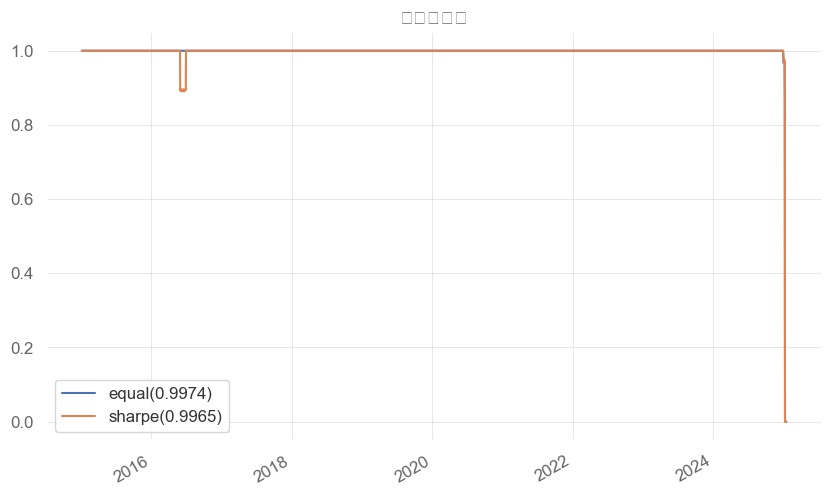

In [50]:
import warnings
warnings.filterwarnings("ignore")
display(pd.concat({"CAGR(%)":bt_ret.mean() * 252 * 100,
        'Sharpe' : bt_ret.mean() / bt_ret.std()*252**0.5,
        'Calmar':bt_ret.mean() * 252 / abs(bt_ret.max_drawdown()),
        'MDD(%)' : bt_ret.max_drawdown()*100,
        '單利MDD(%)' : max_drawdown(bt_ret.cumsum().add(1))*100,
        '樣本勝率(%)' : bt_ret.apply(lambda X:((X.dropna()>0).sum() / X.dropna().shape[0])*100),
        '周勝率(%)' : bt_ret.apply(lambda X:((X.dropna().add(1).resample('W').prod().sub(1)>0).sum() / X.dropna().add(1).resample('W').prod().sub(1).dropna().shape[0])*100),
        '月勝率(%)' : bt_ret.apply(lambda X:((X.dropna().add(1).resample('ME').prod().sub(1)>0).sum() / X.dropna().add(1).resample('ME').prod().sub(1).shape[0])*100),
        '年勝率(%)' : bt_ret.apply(lambda X:((X.dropna().add(1).resample('YE').prod().sub(1)>0).sum() / X.dropna().add(1).resample('YE').prod().sub(1).shape[0])*100),
        'avg_win/avg_loss' : bt_ret.apply(lambda X:(X[X > 0].mean() / abs(X[X < 0].mean()))),
        'profit_factor' : bt_ret.profit_factor(),
        },axis = 1).round(2))
bt_ret.cumsum().ffill().iplot()
# bt_ret.to_drawdown_series().iplot(title = 'Drawdown')
pd.concat({
    f'equal({round(weightings["equal"].loc["2015":].sum(axis=1).mean(), 4)})': weightings['equal'].loc["2015":].sum(axis=1),
    f'sharpe({round(weightings["sharpe"].loc["2015":].sum(axis=1).mean(), 4)})': weightings['sharpe'].loc["2015":].sum(axis=1)
}, axis=1).plot(title='現金使用率')


In [23]:
bt_ret_last10days = bt_ret.iloc[-21:]
bt_ret_last10days.iloc[0] = 0
bt_ret_last10days.cumsum().iplot()

In [180]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import TejToolAPI
os.environ['TEJAPI_KEY'] = 'sPWb8jSlnKgGZG9It37sotLF9DiwMf'
os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'
from zipline.data import bundles
from zipline.api import *
from zipline.finance import commission, slippage
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.pipeline import *
from zipline.TQresearch.tej_pipeline import run_pipeline
from zipline.pipeline.filters import StaticAssets
from datetime import datetime, timedelta
from zipline.pipeline.data import TWEquityPricing
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from zipline.data import bundles
import warnings
warnings.filterwarnings("ignore")

In [273]:
start = '2015-01-01'
end = pd.to_datetime(momentum_factor.index[-1]).strftime('%Y-%m-%d')
# end = '2025.01.10'
pool = list(momentum_factor.columns)
os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(pool+['IR0001']) 

In [276]:
from zipline.utils.calendar_utils import get_calendar
cal = get_calendar('TEJ').all_sessions
cal = cal[(cal >= start) & (cal <= end)]
tradeday = cal.to_series().groupby([cal.year, cal.month]).last().tolist()
tradeday = [str(date.date()) for date in tradeday]
tradeday = pd.to_datetime(tradeday)
tradeday = tradeday[:-1]
print(tradeday)

DatetimeIndex(['2015-01-30', '2015-02-26', '2015-03-31', '2015-04-30',
               '2015-05-29', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-30',
               ...
               '2024-03-29', '2024-04-30', '2024-05-31', '2024-06-28',
               '2024-07-31', '2024-08-30', '2024-09-30', '2024-10-30',
               '2024-11-29', '2024-12-31'],
              dtype='datetime64[ns]', length=120, freq=None)


In [278]:
df_component = TejToolAPI.get_history_data(
    start=start,
    end=end,        
    ticker=pool,  
    columns=["coid", 'Component_Stock_of_TWN50_Fg', "mdate",'Industry','mktcap'],
    transfer_to_chinese=False
    )
df_component

Currently used TEJ API key call quota 324/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 27589683/9223372036854775807 (0.0%)


coid      mdate        Industry Component_Stock_of_TWN50_Fg  \
0        1101 2015-01-05      M1100 水泥工業                           Y   
1        1101 2015-01-06      M1100 水泥工業                           Y   
2        1101 2015-01-07      M1100 水泥工業                           Y   
3        1101 2015-01-08      M1100 水泥工業                           Y   
4        1101 2015-01-09      M1100 水泥工業                           Y   
...       ...        ...             ...                         ...   
3912089  9962 2025-01-03  OTC20 OTC 鋼鐵工業                               
3912090  9962 2025-01-06  OTC20 OTC 鋼鐵工業                               
3912091  9962 2025-01-07  OTC20 OTC 鋼鐵工業                               
3912092  9962 2025-01-08  OTC20 OTC 鋼鐵工業                               
3912093  9962 2025-01-09  OTC20 OTC 鋼鐵工業                               

         Market_Cap_Dollars  
0              1.587636e+11  
1              1.559944e+11  
2              1.554406e+11  
3              1.559944e+11  
4              1.543330e+11  
...                     ...  
3912089        1.326238e+09  
3912090        1.339771e+09  
3912091        1.330749e+09  
3912092        1.312705e+09  
3912093        1.290150e+09  

[3912094 rows x 5 columns]

In [279]:
final_pool = df_component['coid'].unique()

In [280]:
all_dates = df_component['mdate'].unique()
all_coids = df_component['coid'].unique()

complete_index = pd.MultiIndex.from_product([all_dates, all_coids], names=['mdate', 'coid'])

df_component_full = df_component.set_index(['mdate', 'coid']).reindex(complete_index).reset_index()
df_component_full['Market_Cap_Dollars'] = df_component_full['Market_Cap_Dollars'].fillna(0)
df_component_full['Industry'] = df_component_full['Industry'].fillna("M9900 其他")

weights = (
    df_component_full.groupby('mdate')['Market_Cap_Dollars']
    .apply(lambda x: x / x.sum())
)
weights = weights.reset_index(level=0, drop=True) 
df_component_full['Weight'] = weights.values

target_industries = ["M1300 塑膠工業", "M9700 油電燃氣業", "M2300 電子工業", "M2800 金融業", "M2600 航運業"]
df_component_full['Industry'] = df_component_full['Industry'].apply(
    lambda x: x if any(industry in x for industry in target_industries) else "M9900 其他"
)

ind_exp = df_component_full.pivot_table(
    index=['mdate', 'coid'],  
    columns='Industry',      
    values='Weight'       
).fillna(0)

In [282]:
combined_factor = momentum_factor[momentum_factor.index >= '2015-01-05']
combined_factor

coid            1101      1102      1103      1104      1107      1108  \
datetime                                                                 
2015-01-05 -0.000893 -0.000557 -0.000542 -0.001144 -0.000142 -0.000636   
2015-01-06 -0.000917 -0.000620 -0.000503 -0.001025 -0.000135 -0.000496   
2015-01-07 -0.000850 -0.000787 -0.000591 -0.001048 -0.000140 -0.000625   
2015-01-08 -0.000836 -0.000933 -0.000674 -0.000936 -0.000138 -0.000513   
2015-01-09 -0.000632 -0.000769 -0.000683 -0.000675 -0.000152 -0.000474   
...              ...       ...       ...       ...       ...       ...   
2025-01-03  0.001234  0.000800 -0.000674 -0.001051 -0.000104 -0.000849   
2025-01-06  0.001563  0.001125 -0.000747 -0.001355  0.000085 -0.000954   
2025-01-07  0.001506  0.001131 -0.000778 -0.001301  0.000080 -0.000915   
2025-01-08  0.001424  0.000958 -0.000797 -0.001197  0.000056  0.000376   
2025-01-09  0.001404  0.000957 -0.000785 -0.001334  0.000038  0.000324   

coid            1109      1110      1201      1203  ...      9944      9945  \
datetime                                            ...                       
2015-01-05 -0.000774  0.000215 -0.000684 -0.000153  ... -0.000495 -0.000530   
2015-01-06 -0.000739  0.000115 -0.000747 -0.000358  ... -0.000700 -0.000271   
2015-01-07 -0.000645  0.000185 -0.000475 -0.000146  ... -0.000730 -0.000278   
2015-01-08 -0.000520  0.000256 -0.000521  0.000029  ... -0.000437 -0.000415   
2015-01-09 -0.000898 -0.000231 -0.000562  0.000012  ... -0.000568 -0.000351   
...              ...       ...       ...       ...  ...       ...       ...   
2025-01-03 -0.000523  0.000063  0.000134  0.000133  ... -0.000433 -0.000126   
2025-01-06 -0.000595  0.000294 -0.001610  0.000602  ... -0.000765 -0.000134   
2025-01-07 -0.000636  0.000233 -0.001551  0.000482  ... -0.000699 -0.000138   
2025-01-08 -0.000659  0.000165 -0.001530  0.000382  ... -0.000688 -0.000236   
2025-01-09 -0.000671  0.000191 -0.001364  0.000499  ... -0.000842 -0.000234   

coid            9946      9949      9950      9951      9955      9958  \
datetime                                                                 
2015-01-05 -0.001151 -0.001000 -0.000601 -0.000459  0.000931  0.000143   
2015-01-06 -0.001170 -0.000889 -0.000660 -0.000407  0.000653  0.000216   
2015-01-07 -0.000642 -0.000532 -0.000354 -0.000736  0.000673  0.000313   
2015-01-08 -0.000286 -0.000595 -0.000259 -0.000415  0.000713  0.000414   
2015-01-09  0.000334 -0.000491 -0.000381 -0.000429  0.000332 -0.000068   
...              ...       ...       ...       ...       ...       ...   
2025-01-03 -0.000444 -0.000277  0.000048  0.001262 -0.000282 -0.001134   
2025-01-06 -0.000456 -0.000244  0.000394  0.001212 -0.000355 -0.001257   
2025-01-07 -0.000523 -0.000219  0.000368  0.001334 -0.000339 -0.001746   
2025-01-08 -0.000517 -0.000237  0.000332  0.001279 -0.000373 -0.001658   
2025-01-09  0.000136 -0.000288 -0.000863  0.001176  0.000090 -0.001685   

coid            9960      9962  
datetime                        
2015-01-05  0.004736  0.000238  
2015-01-06  0.004527  0.000177  
2015-01-07  0.004921  0.000231  
2015-01-08  0.004791  0.000154  
2015-01-09  0.004809  0.000431  
...              ...       ...  
2025-01-03 -0.000760 -0.000165  
2025-01-06 -0.001078  0.000032  
2025-01-07 -0.001074  0.000024  
2025-01-08 -0.001026 -0.000111  
2025-01-09 -0.001179 -0.002383  

[2445 rows x 1913 columns]

In [291]:
# from zipline.sources.TEJ_Api_Data import get_universe
# bench_pool = get_universe('2015-01-01', '2025-01-09',mkt=['TWSE'], stktp_c=['普通股'])
value = Cache_Handler['個股市值_元']
value.columns = value.columns.droplevel(0)
benchmark_value = value.copy()
benchmark_value.loc[:, ~benchmark_value.columns.isin(bench_pool)] = 0
benchmark_weight = benchmark_value.div(benchmark_value.sum(axis =1), axis = 0)
benchmark_weight = benchmark_weight[final_pool].loc['2015':'2025-01-09']

In [293]:
score = combined_factor
score_index = combined_factor.index
score_columns = combined_factor.columns
benchmark_weight.index = pd.to_datetime(benchmark_weight.index)
score_index = pd.to_datetime(score_index)
benchmark_weight.columns = benchmark_weight.columns.astype(str)
score_columns = score_columns.astype(str)
factor = score.reindex(index=benchmark_weight.index, columns=benchmark_weight.columns, fill_value=0)
factor

coid            1101      1102      1103      1104      1108      1109  \
mdate                                                                    
2015-01-05 -0.000893 -0.000557 -0.000542 -0.001144 -0.000636 -0.000774   
2015-01-06 -0.000917 -0.000620 -0.000503 -0.001025 -0.000496 -0.000739   
2015-01-07 -0.000850 -0.000787 -0.000591 -0.001048 -0.000625 -0.000645   
2015-01-08 -0.000836 -0.000933 -0.000674 -0.000936 -0.000513 -0.000520   
2015-01-09 -0.000632 -0.000769 -0.000683 -0.000675 -0.000474 -0.000898   
...              ...       ...       ...       ...       ...       ...   
2025-01-03  0.001234  0.000800 -0.000674 -0.001051 -0.000849 -0.000523   
2025-01-06  0.001563  0.001125 -0.000747 -0.001355 -0.000954 -0.000595   
2025-01-07  0.001506  0.001131 -0.000778 -0.001301 -0.000915 -0.000636   
2025-01-08  0.001424  0.000958 -0.000797 -0.001197  0.000376 -0.000659   
2025-01-09  0.001404  0.000957 -0.000785 -0.001334  0.000324 -0.000671   

coid            1110      1201      1203      1210  ...      9944      9945  \
mdate                                               ...                       
2015-01-05  0.000215 -0.000684 -0.000153 -0.000184  ... -0.000495 -0.000530   
2015-01-06  0.000115 -0.000747 -0.000358 -0.000222  ... -0.000700 -0.000271   
2015-01-07  0.000185 -0.000475 -0.000146 -0.000201  ... -0.000730 -0.000278   
2015-01-08  0.000256 -0.000521  0.000029 -0.000239  ... -0.000437 -0.000415   
2015-01-09 -0.000231 -0.000562  0.000012  0.000273  ... -0.000568 -0.000351   
...              ...       ...       ...       ...  ...       ...       ...   
2025-01-03  0.000063  0.000134  0.000133  0.000389  ... -0.000433 -0.000126   
2025-01-06  0.000294 -0.001610  0.000602  0.000911  ... -0.000765 -0.000134   
2025-01-07  0.000233 -0.001551  0.000482  0.000864  ... -0.000699 -0.000138   
2025-01-08  0.000165 -0.001530  0.000382  0.000861  ... -0.000688 -0.000236   
2025-01-09  0.000191 -0.001364  0.000499  0.000764  ... -0.000842 -0.000234   

coid            9946      9949      9950      9951      9955      9958  \
mdate                                                                    
2015-01-05 -0.001151 -0.001000 -0.000601 -0.000459  0.000931  0.000143   
2015-01-06 -0.001170 -0.000889 -0.000660 -0.000407  0.000653  0.000216   
2015-01-07 -0.000642 -0.000532 -0.000354 -0.000736  0.000673  0.000313   
2015-01-08 -0.000286 -0.000595 -0.000259 -0.000415  0.000713  0.000414   
2015-01-09  0.000334 -0.000491 -0.000381 -0.000429  0.000332 -0.000068   
...              ...       ...       ...       ...       ...       ...   
2025-01-03 -0.000444 -0.000277  0.000048  0.001262 -0.000282 -0.001134   
2025-01-06 -0.000456 -0.000244  0.000394  0.001212 -0.000355 -0.001257   
2025-01-07 -0.000523 -0.000219  0.000368  0.001334 -0.000339 -0.001746   
2025-01-08 -0.000517 -0.000237  0.000332  0.001279 -0.000373 -0.001658   
2025-01-09  0.000136 -0.000288 -0.000863  0.001176  0.000090 -0.001685   

coid            9960      9962  
mdate                           
2015-01-05  0.004736  0.000238  
2015-01-06  0.004527  0.000177  
2015-01-07  0.004921  0.000231  
2015-01-08  0.004791  0.000154  
2015-01-09  0.004809  0.000431  
...              ...       ...  
2025-01-03 -0.000760 -0.000165  
2025-01-06 -0.001078  0.000032  
2025-01-07 -0.001074  0.000024  
2025-01-08 -0.001026 -0.000111  
2025-01-09 -0.001179 -0.002383  

[2445 rows x 1865 columns]

In [294]:
binary_matrix = factor.columns.isin(bench_pool).astype(int)  
binary_matrix_df = pd.DataFrame(
    np.tile(binary_matrix, (len(factor), 1)),
    index=factor.index,
    columns=factor.columns
)
binary_matrix_df

coid        1101  1102  1103  1104  1108  1109  1110  1201  1203  1210  ...  \
mdate                                                                   ...   
2015-01-05     1     1     1     1     1     1     1     1     1     1  ...   
2015-01-06     1     1     1     1     1     1     1     1     1     1  ...   
2015-01-07     1     1     1     1     1     1     1     1     1     1  ...   
2015-01-08     1     1     1     1     1     1     1     1     1     1  ...   
2015-01-09     1     1     1     1     1     1     1     1     1     1  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2025-01-03     1     1     1     1     1     1     1     1     1     1  ...   
2025-01-06     1     1     1     1     1     1     1     1     1     1  ...   
2025-01-07     1     1     1     1     1     1     1     1     1     1  ...   
2025-01-08     1     1     1     1     1     1     1     1     1     1  ...   
2025-01-09     1     1     1     1     1     1     1     1     1     1  ...   

coid        9944  9945  9946  9949  9950  9951  9955  9958  9960  9962  
mdate                                                                   
2015-01-05     1     1     1     0     0     0     1     1     0     0  
2015-01-06     1     1     1     0     0     0     1     1     0     0  
2015-01-07     1     1     1     0     0     0     1     1     0     0  
2015-01-08     1     1     1     0     0     0     1     1     0     0  
2015-01-09     1     1     1     0     0     0     1     1     0     0  
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
2025-01-03     1     1     1     0     0     0     1     1     0     0  
2025-01-06     1     1     1     0     0     0     1     1     0     0  
2025-01-07     1     1     1     0     0     0     1     1     0     0  
2025-01-08     1     1     1     0     0     0     1     1     0     0  
2025-01-09     1     1     1     0     0     0     1     1     0     0  

[2445 rows x 1865 columns]

In [295]:
first_list = ['收盤價','調整係數','個股市值_元','負債總額','資產總計','股東權益總計','每股淨值','每股稅後淨利','每股營業收入','股利殖利率','成交量_千股','流通在外股數_千股']

In [191]:
merged_data = None
for data in first_list:
    df = Cache_Handler[data]
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(1)  
    
    stacked = df.stack().reset_index()
    stacked.columns = ['mdate', 'coid', data]  
    
    if merged_data is None:
        merged_data = stacked
    else:
        merged_data = pd.merge(merged_data, stacked, on=['mdate', 'coid'], how='outer')

In [192]:
merged_data['收盤價'] = merged_data['收盤價'] * merged_data['調整係數']
merged_data['Size'] = np.log(merged_data['個股市值_元'])
merged_data['Non_Linear_Size'] = merged_data['Size']**3
merged_data['DTOA'] = merged_data['負債總額'] / merged_data['資產總計']
merged_data['BLEV'] = merged_data['負債總額'] / merged_data['股東權益總計']
merged_data['Leverage'] = (
    0.38 * merged_data['個股市值_元'] + 
    0.35 * merged_data['DTOA'] + 
    0.27 * merged_data['BLEV']
)
merged_data['Book_to_Price'] = merged_data['每股淨值'] / merged_data['收盤價']
merged_data['Earnings_to_Price'] = merged_data['每股稅後淨利'] / merged_data['收盤價']
merged_data['Revenue_to_Price'] = merged_data['每股營業收入'] / merged_data['收盤價']
merged_data['Dividend_Yield'] = merged_data['股利殖利率']
merged_data['Momentum'] = (
    merged_data['收盤價'].shift(21) / merged_data['收盤價'].shift(252) - 1
)
merged_data['Short_Term_Reversal'] = (
    merged_data['收盤價'] / merged_data['收盤價'].shift(21) - 1
)

daily_trading_days = 21
def calculate_turnover_rate(df, T, volume_col, shares_col):
    window_size = T * daily_trading_days
    turnover = (
        df[volume_col].rolling(window=window_size).sum() / 
        df[shares_col].rolling(window=window_size).mean()
    )
    return np.log(turnover)
merged_data['STOM'] = calculate_turnover_rate(
    merged_data, 1, volume_col='成交量_千股', shares_col='流通在外股數_千股'
)
merged_data['STOQ'] = calculate_turnover_rate(
    merged_data, 3, volume_col='成交量_千股', shares_col='流通在外股數_千股'
)
merged_data['STOA'] = calculate_turnover_rate(
    merged_data, 12, volume_col='成交量_千股', shares_col='流通在外股數_千股'
)
merged_data['LIQUIDITY'] = (
    0.35 * merged_data['STOM'] + 
    0.35 * merged_data['STOQ'] + 
    0.30 * merged_data['STOA']
)

In [193]:
merged_data = merged_data.drop(columns=['收盤價', '調整係數', '個股市值_元', '負債總額', '資產總計', '股東權益總計',
       '每股淨值', '每股稅後淨利', '每股營業收入', '股利殖利率', '成交量_千股', '流通在外股數_千股','DTOA', 'BLEV', 'STOM', 'STOQ', 'STOA'])

In [194]:
merged_data.set_index('mdate', inplace=True)
merged_data = merged_data.loc['2015':'2024'].reset_index().drop_duplicates(subset=['mdate', 'coid'],keep='last')

In [195]:
data_list = ['Size', 'Non_Linear_Size', 'Leverage', 'Book_to_Price', 'Earnings_to_Price', 'Revenue_to_Price', 'Dividend_Yield', 'Momentum', 'Short_Term_Reversal', 'LIQUIDITY']

In [196]:
mktcap = Cache_Handler['個股市值_元']
mktcap = mktcap.div(mktcap.sum(axis=1), axis=0)
mktcap = mktcap.loc['2015':'2024']
final_data = None
def Zscore_Scaler_Capweight(df:pd.DataFrame, cap:pd.DataFrame) -> pd.DataFrame:
    capWeight = cap.div(cap.sum(axis=1), axis=0)
    return df.sub((df*capWeight).sum(axis=1), axis=0).div(df.std(axis=1), axis=0)

for factor in data_list:
    unstacked = merged_data.pivot(index='mdate', columns='coid', values=factor)  
    standardized = Zscore_Scaler_Capweight(unstacked, mktcap)  
    
    # 重置索引，將標準化結果展開
    standardized = standardized.reset_index()
    standardized = standardized.melt(id_vars='mdate', var_name='coid', value_name=factor)
    
    # 合併數據
    if final_data is None:
        final_data = standardized
    else:
        final_data = pd.merge(final_data, standardized, on=['mdate', 'coid'], how='outer')

In [197]:
final_data.set_index(['mdate','coid'], inplace=True)

In [296]:
import cvxpy as cp
def get_optimal_weights(date, factor, benchmark_weight, ind_exposure, risk_factors, filter):
    # 初始化基準權重數據
    benchmark_weight = benchmark_weight.loc[date].fillna(0)
    factor = factor.loc[date].fillna(0)
    filterbooling = filter.loc[date].fillna(0)
    filterbooling = (filterbooling > 0).astype(float).values

    weights_ = cp.Variable(shape=len(factor))
    W_sub_BW = weights_ - benchmark_weight

    # 目標函數：最大化權重加總的目標因子值
    objective = cp.Maximize(factor.values @ weights_)

    # 定義非負變數 s
    s2 = cp.Variable(1, nonneg=True)
    s3 = cp.Variable(1, nonneg=True)
    s4 = cp.Variable(1, nonneg=True)
    s5 = cp.Variable(1, nonneg=True)
    slack = s4 + s5 + s2 + s3
    objective = cp.Maximize(factor.values @ weights_ - slack * 10)
    constraints = [
        cp.sum(weights_) == 1,  # 權重加總為 1
        weights_ >= 0,  # 權重非負
        weights_ <= 0.1,
        weights_ @ filterbooling >= 1,
        # cp.abs(weights_ - benchmark_weight.values) <= 0.1 + s2,  # 單支股票相對於基準的偏離限制
        # cp.sum(cp.abs(weights_ - benchmark_weight.values)) <= 0.5 + s3,  # 全部股票相對基準權重偏離不得超過 50%
    ]
    if risk_factors is not None:
        risk_factor = risk_factors.loc[date]
        risk_std = risk_factor.std()  
        constraints.append(
            cp.abs(W_sub_BW @ risk_factor.fillna(risk_factor.mean()).values) <= risk_std.values * 0.25+ s4
        )
    if ind_exposure is not None:
        ind_H = ind_exposure.loc[date].fillna(0)
        constraints.append(
            cp.abs(W_sub_BW @ ind_H.values) <= 5 / 100
        )

    problem = cp.Problem(objective, constraints)
    test_count = 2

    while True:
        try:
            Exposure = problem.solve(verbose=False)
            break
        except:
            print(f"{date} 第 {test_count} 次測試")
            test_count += 1
            if test_count > 10:
                print(f"{date} 求解失敗！")
                break

    if Exposure:
        print(f"暴露結果: {Exposure}")

    optimal_weights = pd.Series(weights_.value, index=factor.index)
    return optimal_weights

In [298]:
optimal_weights_list = []
import tqdm
for date in tqdm.tqdm(tradeday):
    optimal_weights = get_optimal_weights(date, factor, benchmark_weight, ind_exp, final_data, binary_matrix_df)
    optimal_weights_list.append(optimal_weights)

  2%|▏         | 2/120 [00:00<00:13,  8.62it/s]

暴露結果: 0.0020110053089804555
暴露結果: 0.0023042553778890116
暴露結果: 0.0016589945226023709


  3%|▎         | 4/120 [00:00<00:11,  9.90it/s]

暴露結果: 0.0018587170558627322
暴露結果: 0.0019104666137052075


  6%|▌         | 7/120 [00:00<00:12,  8.87it/s]

暴露結果: 0.0023912860301669035
暴露結果: 0.0013164933540959875
暴露結果: 0.0008453166715746222


  8%|▊         | 10/120 [00:01<00:11,  9.64it/s]

暴露結果: 0.0007978741244461907
暴露結果: 0.0007883127772995404
暴露結果: 0.0009092389291402785


 11%|█         | 13/120 [00:01<00:11,  9.18it/s]

暴露結果: 0.0009492833252739241
暴露結果: 0.0006709458515470004


 13%|█▎        | 16/120 [00:01<00:10,  9.47it/s]

暴露結果: 0.0006458559602995139
暴露結果: 0.0004859296517119876
暴露結果: 0.0008542181100148063


 15%|█▌        | 18/120 [00:01<00:11,  9.07it/s]

暴露結果: 0.00045832011736901085
暴露結果: 4.871591755763354e-05
暴露結果: -0.9798326718002319


 18%|█▊        | 22/120 [00:02<00:10,  9.65it/s]

暴露結果: -1.2864922952376516
暴露結果: -2.406972997783695
暴露結果: -2.6396886601165734


 21%|██        | 25/120 [00:02<00:09, 10.03it/s]

暴露結果: -1.2386583958683197
暴露結果: -0.7411503092650269
暴露結果: -0.9418138688103262


 22%|██▎       | 27/120 [00:02<00:09,  9.57it/s]

暴露結果: -0.6220857222071672
暴露結果: -0.2983561007560532


 24%|██▍       | 29/120 [00:03<00:10,  9.04it/s]

暴露結果: -1.2367589680069324
暴露結果: -2.6660942342043996


 25%|██▌       | 30/120 [00:03<00:09,  9.16it/s]

暴露結果: -2.44041482180844
暴露結果: -4.306938096603474


 27%|██▋       | 32/120 [00:03<00:09,  9.41it/s]

暴露結果: -3.8372563662799113
暴露結果: -4.724798561497475
暴露結果: -10.56967918350058


 30%|███       | 36/120 [00:03<00:08,  9.37it/s]

暴露結果: -6.107502864773296
暴露結果: -6.102602411832771


 32%|███▏      | 38/120 [00:04<00:10,  7.84it/s]

暴露結果: -11.412727753972627
暴露結果: -10.20122963557286


 33%|███▎      | 40/120 [00:04<00:10,  7.97it/s]

暴露結果: -9.796382330036426
暴露結果: -4.9971379606828625
暴露結果: -3.309847582532151


 36%|███▌      | 43/120 [00:04<00:08,  8.62it/s]

暴露結果: -1.4835389659196485
暴露結果: -7.837196602920373


 38%|███▊      | 45/120 [00:04<00:09,  8.18it/s]

暴露結果: -11.369401567053325
暴露結果: -14.036810222097223


 39%|███▉      | 47/120 [00:05<00:09,  7.86it/s]

暴露結果: -13.812166694323386
暴露結果: -10.497428820078087


 41%|████      | 49/120 [00:05<00:08,  8.13it/s]

暴露結果: -11.764306881380412
暴露結果: -8.830203570794325
暴露結果: -12.222998660874971


 43%|████▎     | 52/120 [00:05<00:08,  7.89it/s]

暴露結果: -12.364782806619681
暴露結果: -14.874253198163064


 45%|████▌     | 54/120 [00:06<00:08,  8.04it/s]

暴露結果: -9.92569180235877
暴露結果: -9.658927765281243


 47%|████▋     | 56/120 [00:06<00:08,  7.35it/s]

暴露結果: -17.80979238089143
暴露結果: -19.7027380141163


 48%|████▊     | 58/120 [00:06<00:09,  6.59it/s]

暴露結果: -22.65145726704974
暴露結果: -27.714424660217453


 50%|█████     | 60/120 [00:07<00:09,  6.33it/s]

暴露結果: -28.596120398179387
暴露結果: -32.97531998515884


 52%|█████▏    | 62/120 [00:07<00:09,  6.05it/s]

暴露結果: -34.37578810558272
暴露結果: -35.26574703275902


 52%|█████▎    | 63/120 [00:07<00:09,  5.74it/s]

暴露結果: -35.75859756084284
暴露結果: -33.583508513896724


 55%|█████▌    | 66/120 [00:08<00:09,  5.90it/s]

暴露結果: -29.64770174717012
暴露結果: -30.347941318382656


 57%|█████▋    | 68/120 [00:08<00:08,  5.83it/s]

暴露結果: -58.62203559699344
暴露結果: -60.47435949692471


 58%|█████▊    | 70/120 [00:08<00:08,  5.76it/s]

暴露結果: -63.03965753245006
暴露結果: -62.23183657072218


 59%|█████▉    | 71/120 [00:08<00:08,  5.52it/s]

暴露結果: -65.45184210432032


 61%|██████    | 73/120 [00:09<00:09,  5.18it/s]

暴露結果: -inf
暴露結果: -inf


 62%|██████▏   | 74/120 [00:09<00:09,  5.07it/s]

暴露結果: -inf


 63%|██████▎   | 76/120 [00:10<00:09,  4.78it/s]

暴露結果: -inf
暴露結果: -60.1640519395917


 64%|██████▍   | 77/120 [00:10<00:09,  4.65it/s]

暴露結果: -64.26465963841892
暴露結果: -57.787808386997405


 66%|██████▌   | 79/120 [00:10<00:08,  5.07it/s]

暴露結果: -58.663868336995726


 68%|██████▊   | 81/120 [00:11<00:07,  5.03it/s]

暴露結果: -65.00443640641001
暴露結果: -60.34447321541583


 69%|██████▉   | 83/120 [00:11<00:06,  5.38it/s]

暴露結果: -62.77733987844932
暴露結果: -60.652496775909114


 70%|███████   | 84/120 [00:11<00:06,  5.54it/s]

暴露結果: -58.32215599546926


 71%|███████   | 85/120 [00:11<00:07,  4.72it/s]

暴露結果: -inf
暴露結果: -59.41002685585033


 73%|███████▎  | 88/120 [00:12<00:06,  5.19it/s]

暴露結果: -58.04292748148625
暴露結果: -52.13024182362053


 75%|███████▌  | 90/120 [00:12<00:05,  5.45it/s]

暴露結果: -56.01784809891709
暴露結果: -50.266101437026485


 77%|███████▋  | 92/120 [00:13<00:04,  5.66it/s]

暴露結果: -58.15157310928298
暴露結果: -56.5085860430144


 78%|███████▊  | 94/120 [00:13<00:04,  5.70it/s]

暴露結果: -47.79038753418414
暴露結果: -41.689349326217176


 80%|████████  | 96/120 [00:13<00:04,  5.98it/s]

暴露結果: -53.60527218492937
暴露結果: -48.842758459774245


 82%|████████▏ | 98/120 [00:14<00:03,  5.93it/s]

暴露結果: -58.957697779357915
暴露結果: -54.19307261051107


 82%|████████▎ | 99/120 [00:14<00:03,  5.92it/s]

暴露結果: -56.475229099888786
暴露結果: -51.01040616092903


 84%|████████▍ | 101/120 [00:14<00:03,  5.63it/s]

暴露結果: -56.86990697133959
暴露結果: -58.84234349353487


 86%|████████▌ | 103/120 [00:15<00:03,  5.52it/s]

暴露結果: -53.84706569566551
暴露結果: -53.61928691796746


 88%|████████▊ | 106/120 [00:15<00:02,  5.93it/s]

暴露結果: -49.64206494980575
暴露結果: -53.8254334370645


 89%|████████▉ | 107/120 [00:15<00:02,  6.08it/s]

暴露結果: -54.05429646187702


 91%|█████████ | 109/120 [00:16<00:01,  5.53it/s]

暴露結果: -53.84488087046714
暴露結果: -61.85967512254165


 92%|█████████▏| 110/120 [00:16<00:01,  5.56it/s]

暴露結果: -67.22766374654599


 93%|█████████▎| 112/120 [00:16<00:01,  5.17it/s]

暴露結果: -inf
暴露結果: -inf


 95%|█████████▌| 114/120 [00:17<00:01,  5.30it/s]

暴露結果: -inf
暴露結果: -inf


 97%|█████████▋| 116/120 [00:17<00:00,  5.50it/s]

暴露結果: -inf
暴露結果: -inf


 98%|█████████▊| 118/120 [00:17<00:00,  6.06it/s]

暴露結果: -inf
暴露結果: -inf


100%|██████████| 120/120 [00:17<00:00,  6.67it/s]

暴露結果: -inf
暴露結果: -inf


In [305]:
optimal_weights_df = pd.concat(optimal_weights_list, axis = 1, keys = tradeday).T
optimal_weights_df = optimal_weights_df.round(4)
optimal_weights_df = optimal_weights_df.clip(lower=0)
optimal_weights_df = optimal_weights_df.div(optimal_weights_df.sum(axis =1), axis = 0)
optimal_weights_df.index = pd.to_datetime(optimal_weights_df.index)
factor.index = pd.to_datetime(factor.index)
optimal_weights_df = optimal_weights_df.reindex(columns=factor.columns)
optimal_weights_df = optimal_weights_df.reindex(factor.index, method = 'ffill').fillna(method = 'ffill')
optimal_weights_df.columns.name = 'asset'
optimal_weights_df

asset       1101  1102  1103  1104  1108  1109  1110  1201  1203  1210  ...  \
mdate                                                                   ...   
2015-01-05   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2015-01-06   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2015-01-07   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2015-01-08   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2015-01-09   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2025-01-03  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  ...   
2025-01-06  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  ...   
2025-01-07  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  ...   
2025-01-08  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  ...   
2025-01-09  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  ...   

asset       9944  9945  9946  9949  9950  9951  9955  9958  9960  9962  
mdate                                                                   
2015-01-05   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2015-01-06   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2015-01-07   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2015-01-08   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2015-01-09   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
2025-01-03  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  
2025-01-06  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  
2025-01-07  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  
2025-01-08  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  
2025-01-09  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  

[2445 rows x 1865 columns]

In [306]:
optimal_weights_df.sum(axis=1).iplot(title='權重加總')

In [326]:
weighting = (np.floor((optimal_weights_df * AUM) / (1000 * adj_close))) * (1000 * adj_close) / AUM
weighting.replace({0: np.nan}, inplace=True)
delta_weighting = weighting.diff()
day_buy_fee = delta_weighting[delta_weighting > 0] * (0.001425 * 0.3 + 0.003)
day_sell_fee = delta_weighting[delta_weighting < 0].abs() * (0.001425 * 0.3)
return_series = ((weighting * exp_ret) - day_buy_fee.fillna(0) - day_sell_fee.fillna(0)).sum(axis=1).loc['2015':]